In [1]:
%load_ext autoreload
%autoreload 2
import torch
import imageio
import sys
import io
import matplotlib.pyplot as plt
sys.path.append("../radialmri/")
from simulation_and_reconstruction import *

/gpfs/share/apps/anaconda3/gpu/5.2.0/lib/python3.6/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
../radialmri/simulation_and_reconstruction.py:23: UserWarning: Out of sync with the remove repository
  warnings.warn('Out of sync with the remove repository')


In [2]:
device = torch.device('cuda')

# 1.0 intruduce 2 regions, roi has linearly increasing signal while roi2 has constant signal

## 1.1 off-centered simulation

x, y, wx, wy, nt, x_shift, y_shift = 320, 320, 60, 60, 22, 40, 40
pt = torch.zeros((nt, 2, 320, 320), device = device)
pt[:, :, x_shift + x // 2 - wx : x_shift + x // 2 + wx, x_shift + y // 2 - wy : x_shift + y // 2 + wy] = 1
plt.imshow(pt[0, 0].cpu(), cmap = 'gray')
plt.show()

#introduce a linear temporal variation
for i in range(5, nt):
    pt[i, : , x_shift + x // 2 - wx // 2 : x_shift + x // 2 + wx // 2, y_shift + y // 2 - wy // 2: y_shift + y // 2 + wy // 2] *= (i - 4)

maskdict = {'all' : np.ones((x, y))}

maskdict['roi'] = np.zeros((x, y))
maskdict['roi'][x_shift + x // 2 - wx // 2 : x_shift + x // 2 + wx // 2, y_shift + y // 2 - wy // 2 : y_shift + y // 2 + wy // 2] = 1

maskdict['roi2'] = np.zeros((x, y))
maskdict['roi2'][x_shift + x // 2 - wx : x_shift + x // 2 + wx, y_shift + y // 2 - wy : y_shift + y // 2 + wy] = 1
maskdict['roi2'] -= maskdict['roi']

maskdict['background'] = maskdict['all'] - maskdict['roi'] - maskdict['roi2']


kspace, recon, traj, dcomp = RadialSimulation(target= torch.tensor(pt, dtype = torch.float32).to(device), 
                                                 spokespertime= 21, nt= 22, nc = 1, spokelength= 640, 
                                                 smap= (2 ** (-0.5)) * torch.ones((1, 1, 2, x, y) , dtype = torch.float32).to(device), 
                                                 grid_size= (640, 640), im_size= (320, 320))

plotcoil(torch.sqrt(recon[:, 0]**2 + recon[:, 1]**2).cpu(), n = 8)

plotcurves(x_hat = recon.cpu(). numpy(), 
           x_gt = pt.cpu(). numpy(), 
           maskdict = maskdict,
           names = ['adjnufft', 'GT'], 
           normalize = True)

for k, v in maskdict.items():
    plt.imshow(v, vmin = 0, vmax = 1)
    plt.title(k)
    plt.show()

## 1.2 centered simulation

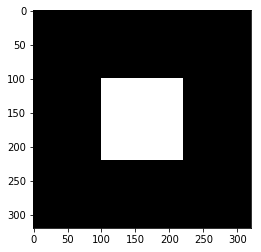

/gpfs/share/apps/anaconda3/gpu/5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([22, 1, 2, 13440])
torch.Size([22, 1, 2, 13440])
torch.Size([22, 2, 320, 320])


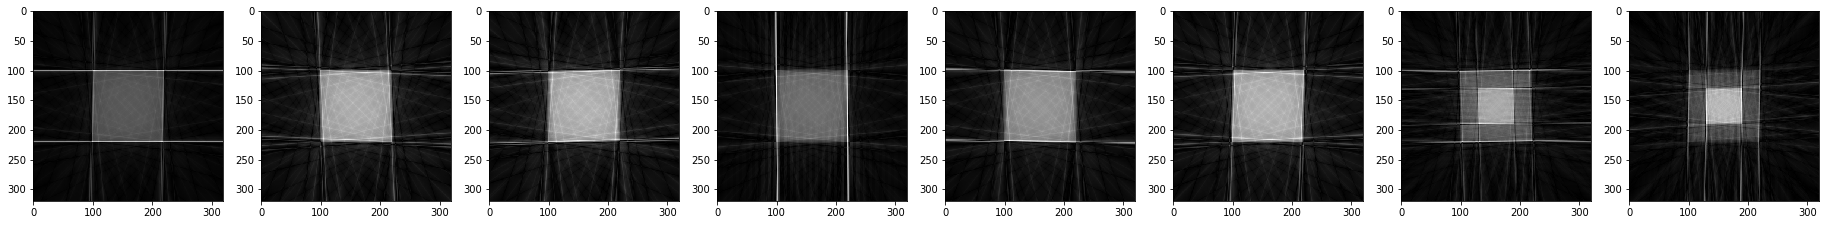

(22,)


../radialmri/simulation_and_reconstruction.py:227: RuntimeWarning: invalid value encountered in true_divide
  return curve/m;


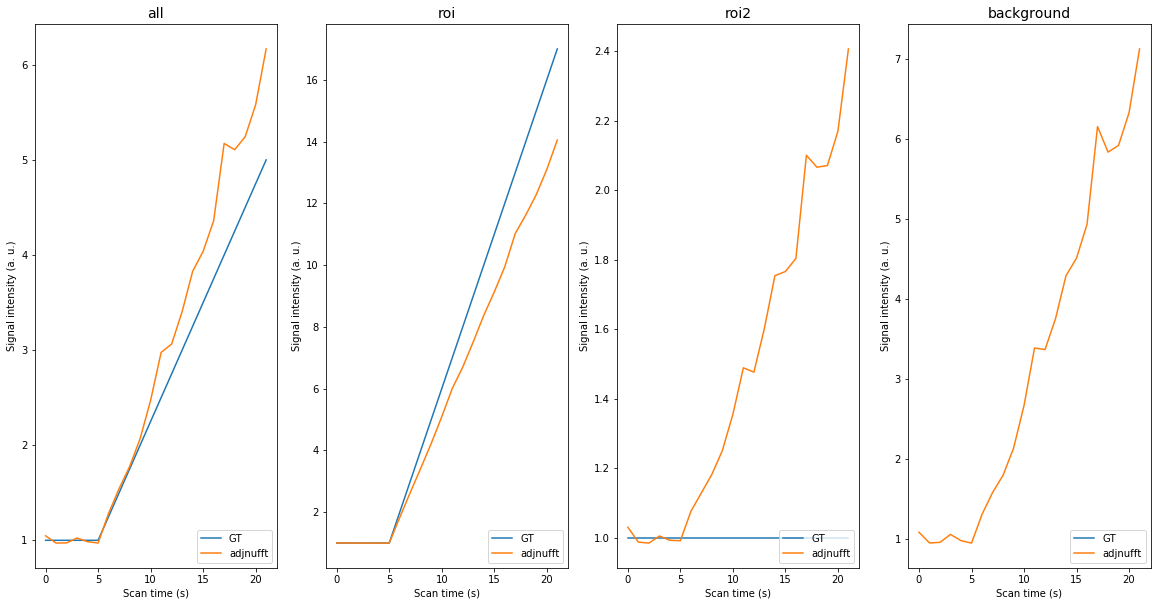

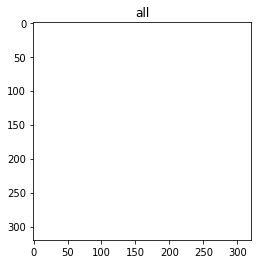

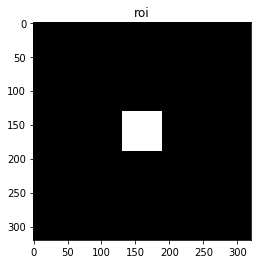

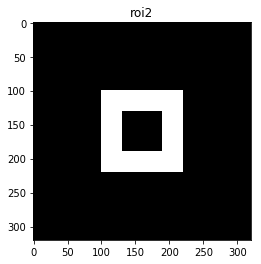

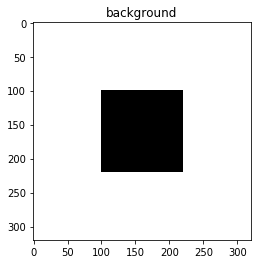

In [3]:
x, y, wx, wy, nt, x_shift, y_shift = 320, 320, 60, 60, 22, 0, 0
pt = torch.zeros((nt, 2, 320, 320), device = device)
pt[:, :, x_shift + x // 2 - wx : x_shift + x // 2 + wx, x_shift + y // 2 - wy : x_shift + y // 2 + wy] = 1
plt.imshow(pt[0, 0].cpu(), cmap = 'gray')
plt.show()

#introduce a linear temporal variation
for i in range(5, nt):
    pt[i, : , x_shift + x // 2 - wx // 2 : x_shift + x // 2 + wx // 2, y_shift + y // 2 - wy // 2: y_shift + y // 2 + wy // 2] *= (i - 4)

maskdict = {'all' : np.ones((x, y))}

maskdict['roi'] = np.zeros((x, y))
maskdict['roi'][x_shift + x // 2 - wx // 2 : x_shift + x // 2 + wx // 2, y_shift + y // 2 - wy // 2 : y_shift + y // 2 + wy // 2] = 1

maskdict['roi2'] = np.zeros((x, y))
maskdict['roi2'][x_shift + x // 2 - wx : x_shift + x // 2 + wx, y_shift + y // 2 - wy : y_shift + y // 2 + wy] = 1
maskdict['roi2'] -= maskdict['roi']

maskdict['background'] = maskdict['all'] - maskdict['roi'] - maskdict['roi2']


kspace, recon, traj, dcomp = RadialSimulation(target= torch.tensor(pt, dtype = torch.float32).to(device), 
                                                 spokespertime= 21, nt= 22, nc = 1, spokelength= 640, 
                                                 smap= (2 ** (-0.5)) * torch.ones((1, 1, 2, x, y) , dtype = torch.float32).to(device), 
                                                 grid_size= (640, 640), im_size= (320, 320))

plotcoil(torch.sqrt(recon[:, 0]**2 + recon[:, 1]**2).cpu(), n = 8)

plotcurves(x_hat = recon.cpu(). numpy(), 
           x_gt = pt.cpu(). numpy(), 
           maskdict = maskdict,
           names = ['adjnufft', 'GT'], 
           normalize = True)

for k, v in maskdict.items():
    plt.imshow(v, vmin = 0, vmax = 1)
    plt.title(k)
    plt.show()

# 2.1 CG, with density compensation

0 alpha:  tensor([ 1.4803e+01, -2.4144e-07], device='cuda:0')
1 alpha:  tensor([ 4.8930e+00, -1.0708e-07], device='cuda:0')
2 alpha:  tensor([ 4.6826e+00, -3.0223e-08], device='cuda:0')
3 alpha:  tensor([ 5.1269e+00, -6.2653e-08], device='cuda:0')
4 alpha:  tensor([ 4.7299e+00, -1.0014e-08], device='cuda:0')
5 alpha:  tensor([ 4.0533e+00, -8.6460e-09], device='cuda:0')
6 alpha:  tensor([ 4.3630e+00, -5.3222e-08], device='cuda:0')
7 alpha:  tensor([ 4.3121e+00, -2.3271e-08], device='cuda:0')
8 alpha:  tensor([ 3.9899e+00, -4.5998e-08], device='cuda:0')
9 alpha:  tensor([ 4.3316e+00, -3.2487e-08], device='cuda:0')
10 alpha:  tensor([ 4.9342e+00, -5.7229e-08], device='cuda:0')
11 alpha:  tensor([ 5.0220e+00, -2.0975e-08], device='cuda:0')


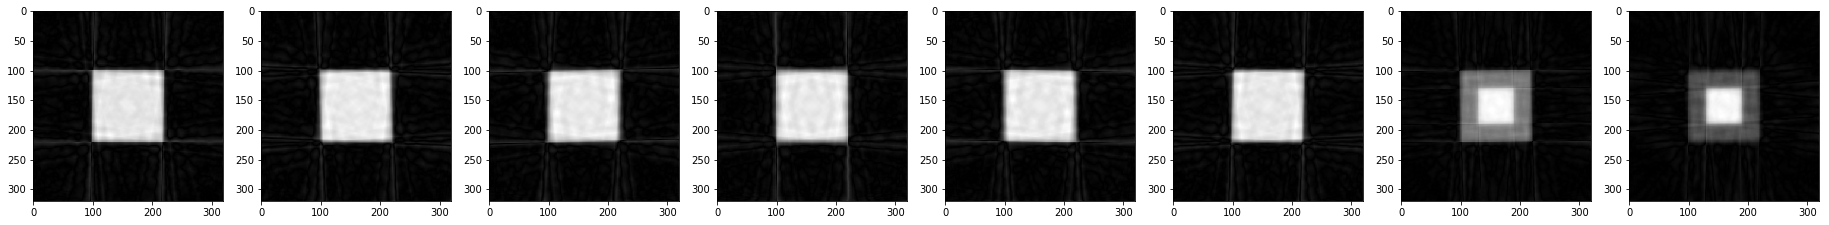

(22,)


../radialmri/simulation_and_reconstruction.py:227: RuntimeWarning: invalid value encountered in true_divide
  return curve/m;


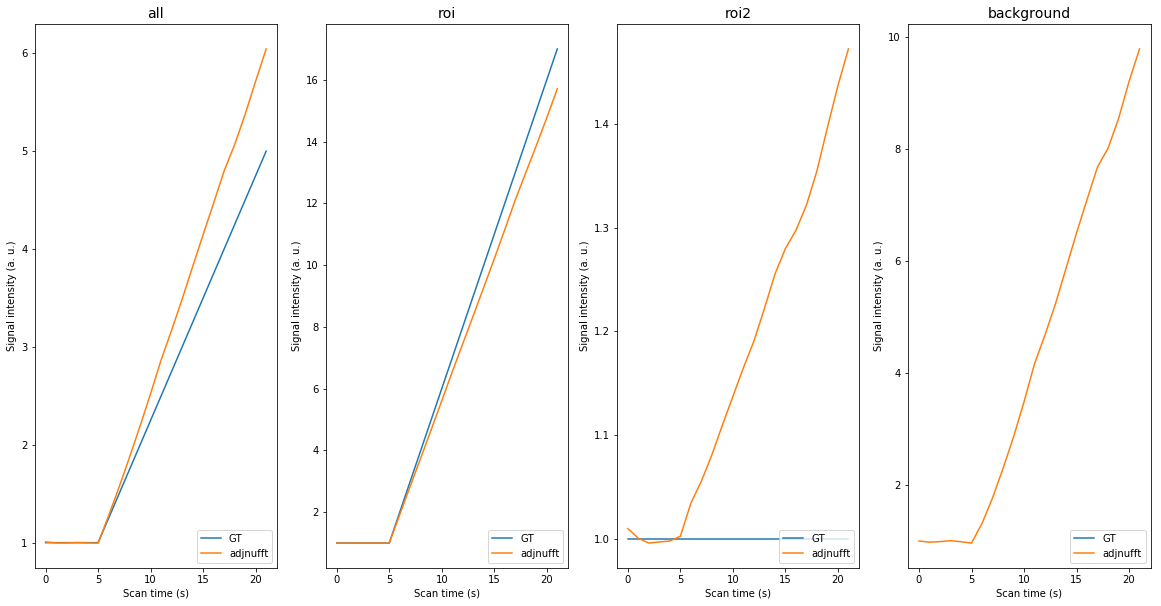

In [4]:
dcomp_trivial = torch.ones(dcomp.shape).to(device)

CG_recon, nufft_recon = \
RadialRecon_alternative(kspace= kspace.to(device), 
            traj = traj.to(device), 
            coil_sensitivities= (2 ** (-0.5)) * torch.ones((1, 1, 2, x, y), dtype = torch.float32).to(device), 
            w = dcomp.to(device), 
            #w = dcomp_trivial.to(device), 
            grid_size = (640, 640),
            im_size = (320, 320), 
            tolerance = 1e-10,
            lambda1 = None,
            niter = 12,
            optimizer = 'CG5')

CG_recon_complex = CG_recon[:,0] + 1j * CG_recon[:,0]

plotcoil(np.abs(CG_recon_complex))
plotcurves(x_hat = np.abs(CG_recon_complex), 
           x_gt = pt.cpu(). numpy(), 
           maskdict = maskdict,
           names = ['adjnufft', 'GT'], 
           normalize = True)

0 alpha:  tensor([ 1.4803e+01, -2.2230e-07], device='cuda:0')
1 alpha:  tensor([ 4.8930e+00, -1.2317e-07], device='cuda:0')
2 alpha:  tensor([ 4.6826e+00, -3.4498e-08], device='cuda:0')
3 alpha:  tensor([ 5.1269e+00, -6.1038e-08], device='cuda:0')
4 alpha:  tensor([ 4.7299e+00, -1.0826e-08], device='cuda:0')
5 alpha:  tensor([ 4.0533e+00, -8.7650e-09], device='cuda:0')
6 alpha:  tensor([ 4.3630e+00, -4.5080e-08], device='cuda:0')
7 alpha:  tensor([ 4.3121e+00, -2.3804e-08], device='cuda:0')
8 alpha:  tensor([ 3.9899e+00, -5.0104e-08], device='cuda:0')
9 alpha:  tensor([ 4.3316e+00, -3.9947e-08], device='cuda:0')
10 alpha:  tensor([ 4.9342e+00, -5.1536e-08], device='cuda:0')
11 alpha:  tensor([ 5.0220e+00, -2.4753e-08], device='cuda:0')
12 alpha:  tensor([ 4.7807e+00, -4.7081e-08], device='cuda:0')
13 alpha:  tensor([ 4.0293e+00, -4.2797e-08], device='cuda:0')
14 alpha:  tensor([ 3.3935e+00, -4.6679e-08], device='cuda:0')
15 alpha:  tensor([ 3.9058e+00, -3.8818e-08], device='cuda:0')
16

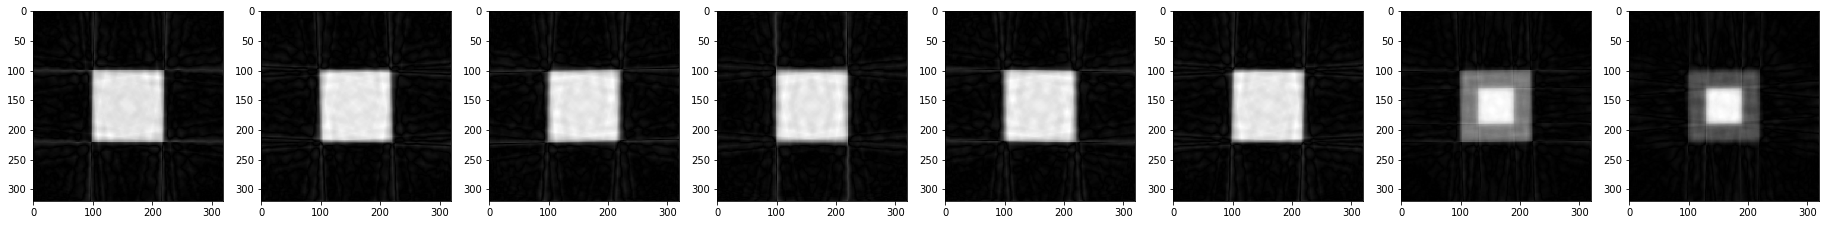

(22,)


../radialmri/simulation_and_reconstruction.py:227: RuntimeWarning: invalid value encountered in true_divide
  return curve/m;


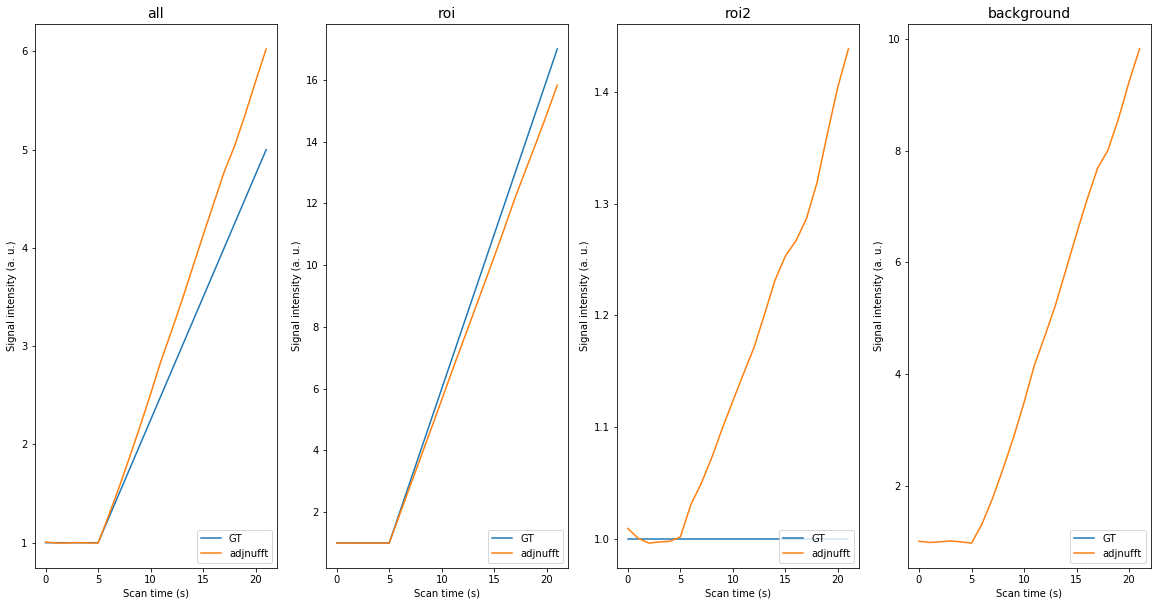

In [5]:
dcomp_trivial = torch.ones(dcomp.shape).to(device)

CG_recon, nufft_recon = \
RadialRecon_alternative(kspace= kspace.to(device), 
            traj = traj.to(device), 
            coil_sensitivities= (2 ** (-0.5)) * torch.ones((1, 1, 2, x, y), dtype = torch.float32).to(device), 
            w = dcomp.to(device), 
            #w = dcomp_trivial.to(device), 
            grid_size = (640, 640),
            im_size = (320, 320), 
            tolerance = 1e-10,
            lambda1 = None,
            niter = 32,
            optimizer = 'CG5')

CG_recon_complex = CG_recon[:,0] + 1j * CG_recon[:,0]

plotcoil(np.abs(CG_recon_complex))
plotcurves(x_hat = np.abs(CG_recon_complex), 
           x_gt = pt.cpu(). numpy(), 
           maskdict = maskdict,
           names = ['adjnufft', 'GT'], 
           normalize = True)

# 2.2 CG5 no density compensation

0 alpha:  tensor([ 1.2297e-01, -2.3397e-09], device='cuda:0')
1 alpha:  tensor([ 3.5932e-01, -5.3189e-09], device='cuda:0')
2 alpha:  tensor([ 6.4819e-01, -3.3745e-08], device='cuda:0')
3 alpha:  tensor([ 8.3619e-01, -1.5712e-08], device='cuda:0')
4 alpha:  tensor([ 1.3689e-01, -2.7304e-09], device='cuda:0')
5 alpha:  tensor([ 8.7142e-01, -2.3646e-08], device='cuda:0')
6 alpha:  tensor([ 6.8816e-01, -2.5966e-08], device='cuda:0')
7 alpha:  tensor([ 6.7224e-01, -2.2283e-08], device='cuda:0')
8 alpha:  tensor([ 1.6881e-01, -3.6643e-09], device='cuda:0')
9 alpha:  tensor([ 7.0625e-01, -2.2473e-08], device='cuda:0')
10 alpha:  tensor([ 6.3775e-01, -1.3082e-08], device='cuda:0')
11 alpha:  tensor([ 1.1356e+00, -2.7142e-08], device='cuda:0')
12 alpha:  tensor([ 3.5299e-01, -8.4265e-09], device='cuda:0')
13 alpha:  tensor([ 4.6493e-01, -1.1249e-08], device='cuda:0')
14 alpha:  tensor([ 8.2158e-01, -9.1368e-09], device='cuda:0')
15 alpha:  tensor([ 1.3522e+00, -3.4550e-08], device='cuda:0')
16

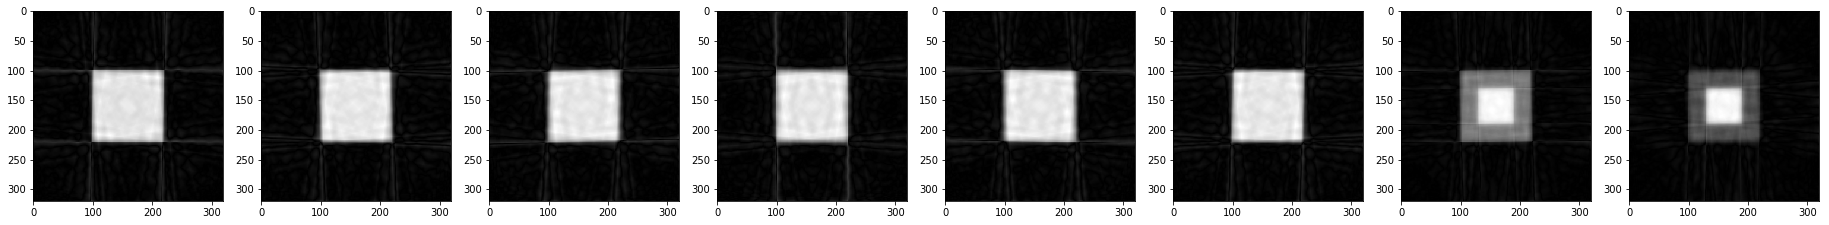

(22,)


../radialmri/simulation_and_reconstruction.py:227: RuntimeWarning: invalid value encountered in true_divide
  return curve/m;


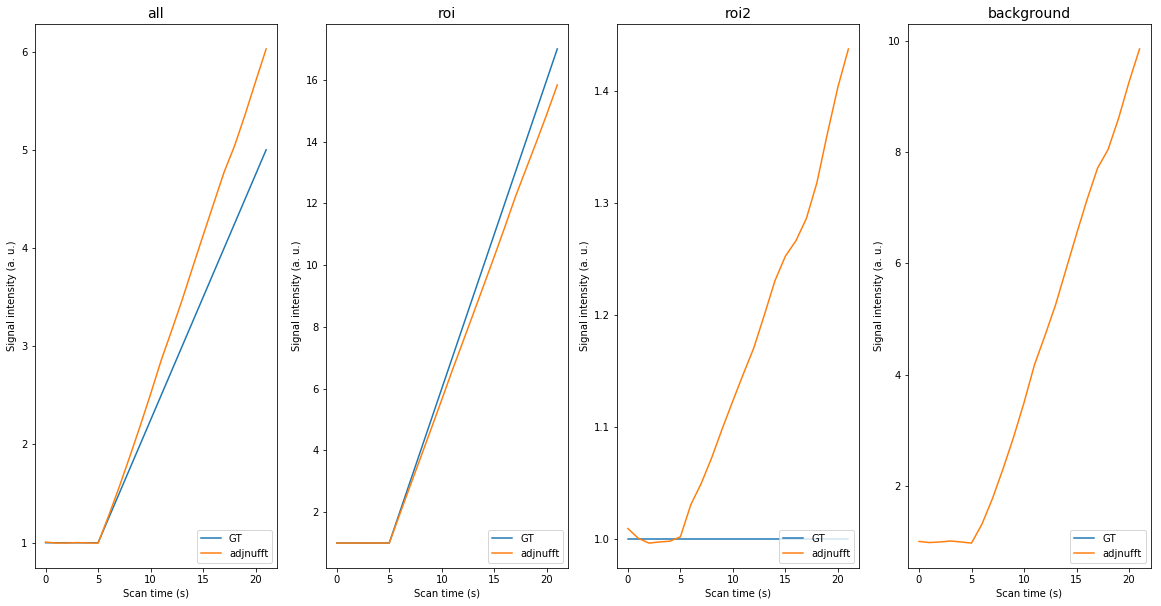

In [7]:
dcomp_trivial = torch.ones(dcomp.shape).to(device)

CG_recon, nufft_recon = \
RadialRecon_alternative(kspace= kspace.to(device), 
            traj = traj.to(device), 
            coil_sensitivities= (2 ** (-0.5)) * torch.ones((1, 1, 2, x, y), dtype = torch.float32).to(device), 
            #w = dcomp.to(device), 
            w = dcomp_trivial.to(device), 
            grid_size = (640, 640),
            im_size = (320, 320), 
            tolerance = 1e-10,
            lambda1 = None,
            niter = 32,
            optimizer = 'CG5')

CG_recon_complex = CG_recon[:,0] + 1j * CG_recon[:,0]

plotcoil(np.abs(CG_recon_complex))
plotcurves(x_hat = np.abs(CG_recon_complex), 
           x_gt = pt.cpu(). numpy(), 
           maskdict = maskdict,
           names = ['adjnufft', 'GT'], 
           normalize = True)

0 alpha:  tensor([ 1.2297e-01, -2.7665e-09], device='cuda:0')
1 alpha:  tensor([ 3.5932e-01, -5.0189e-09], device='cuda:0')
2 alpha:  tensor([ 6.4819e-01, -3.1942e-08], device='cuda:0')
3 alpha:  tensor([ 8.3621e-01, -1.4876e-08], device='cuda:0')
4 alpha:  tensor([ 1.3689e-01, -3.0655e-09], device='cuda:0')
5 alpha:  tensor([ 8.7139e-01, -2.3748e-08], device='cuda:0')
6 alpha:  tensor([ 6.8816e-01, -2.5238e-08], device='cuda:0')
7 alpha:  tensor([ 6.7224e-01, -2.2734e-08], device='cuda:0')
8 alpha:  tensor([ 1.6882e-01, -3.8629e-09], device='cuda:0')
9 alpha:  tensor([ 7.0624e-01, -2.2287e-08], device='cuda:0')
10 alpha:  tensor([ 6.3775e-01, -1.3492e-08], device='cuda:0')
11 alpha:  tensor([ 1.1356e+00, -2.4503e-08], device='cuda:0')
12 alpha:  tensor([ 3.5304e-01, -8.4940e-09], device='cuda:0')
13 alpha:  tensor([ 4.6484e-01, -1.1571e-08], device='cuda:0')
14 alpha:  tensor([ 8.2092e-01, -1.2745e-08], device='cuda:0')
15 alpha:  tensor([ 1.3441e+00, -3.6644e-08], device='cuda:0')
16

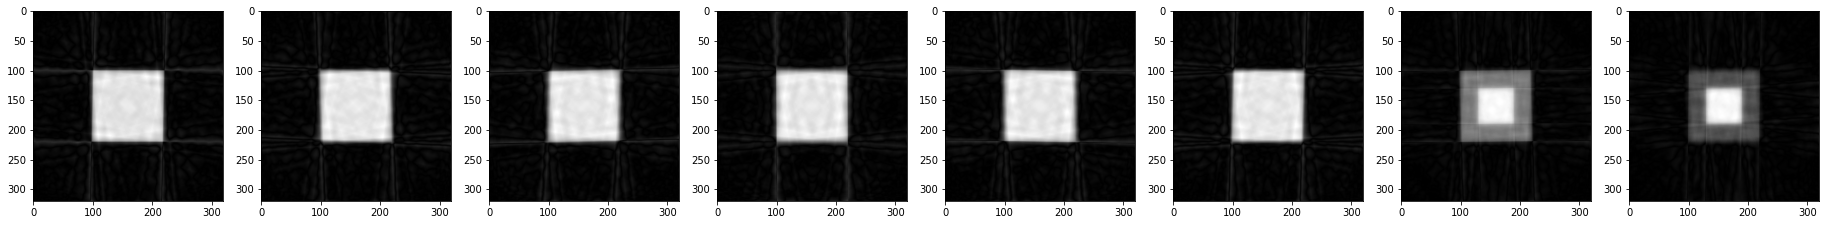

(22,)


../radialmri/simulation_and_reconstruction.py:226: RuntimeWarning: invalid value encountered in true_divide
  return curve/m;


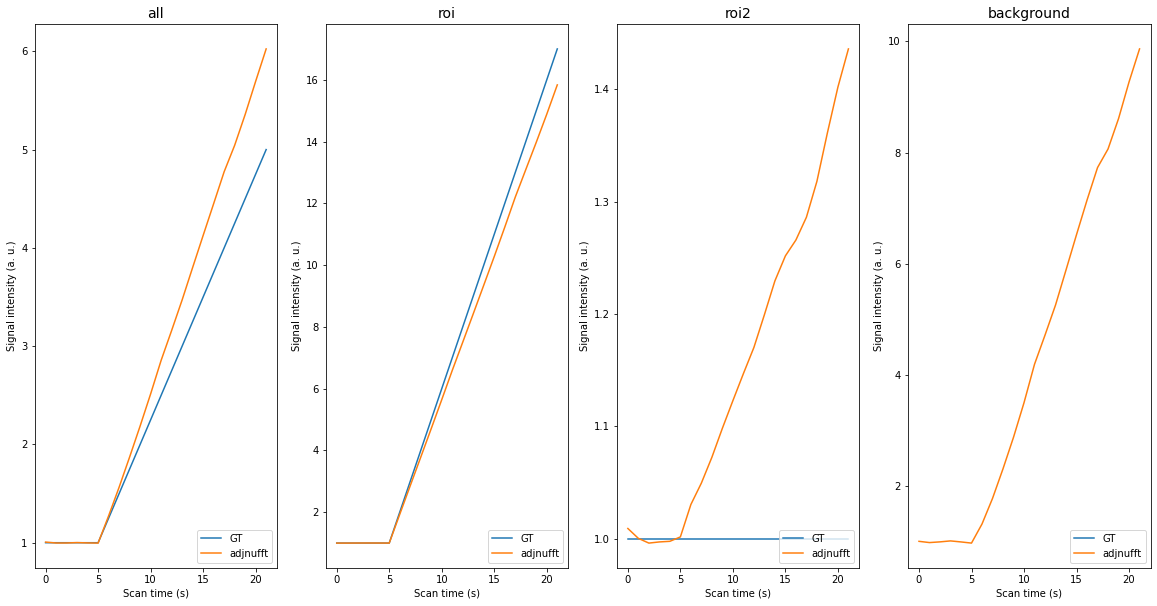

In [52]:
dcomp_trivial = torch.ones(dcomp.shape).to(device)

CG_recon, nufft_recon = \
RadialRecon_alternative(kspace= kspace.to(device), 
            traj = traj.to(device), 
            coil_sensitivities= (2 ** (-0.5)) * torch.ones((1, 1, 2, x, y), dtype = torch.float32).to(device), 
            #w = dcomp.to(device), 
            w = dcomp_trivial.to(device), 
            grid_size = (640, 640),
            im_size = (320, 320), 
            tolerance = 1e-10,
            lambda1 = None,
            niter = 64,
            optimizer = 'CG5')

CG_recon_complex = CG_recon[:,0] + 1j * CG_recon[:,0]

plotcoil(np.abs(CG_recon_complex))
plotcurves(x_hat = np.abs(CG_recon_complex), 
           x_gt = pt.cpu(). numpy(), 
           maskdict = maskdict,
           names = ['adjnufft', 'GT'], 
           normalize = True)

0 alpha:  tensor([ 1.2297e-01, -2.5023e-09], device='cuda:0')
1 alpha:  tensor([ 3.5932e-01, -5.8276e-09], device='cuda:0')
2 alpha:  tensor([ 6.4819e-01, -3.1833e-08], device='cuda:0')
3 alpha:  tensor([ 8.3620e-01, -1.6877e-08], device='cuda:0')
4 alpha:  tensor([ 1.3689e-01, -2.9082e-09], device='cuda:0')
5 alpha:  tensor([ 8.7140e-01, -2.5586e-08], device='cuda:0')
6 alpha:  tensor([ 6.8816e-01, -2.5484e-08], device='cuda:0')
7 alpha:  tensor([ 6.7225e-01, -2.2684e-08], device='cuda:0')
8 alpha:  tensor([ 1.6883e-01, -3.0202e-09], device='cuda:0')
9 alpha:  tensor([ 7.0617e-01, -2.0975e-08], device='cuda:0')
10 alpha:  tensor([ 6.3775e-01, -1.0991e-08], device='cuda:0')
11 alpha:  tensor([ 1.1357e+00, -2.6303e-08], device='cuda:0')
12 alpha:  tensor([ 3.5308e-01, -7.3402e-09], device='cuda:0')
13 alpha:  tensor([ 4.6484e-01, -1.2252e-08], device='cuda:0')
14 alpha:  tensor([ 8.2220e-01, -1.2378e-08], device='cuda:0')
15 alpha:  tensor([ 1.3607e+00, -3.7659e-08], device='cuda:0')
16

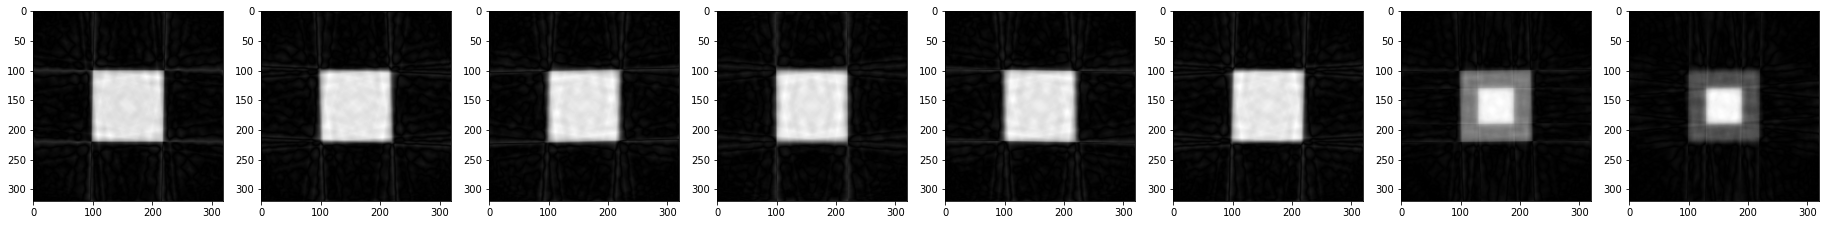

(22,)


../radialmri/simulation_and_reconstruction.py:226: RuntimeWarning: invalid value encountered in true_divide
  return curve/m;


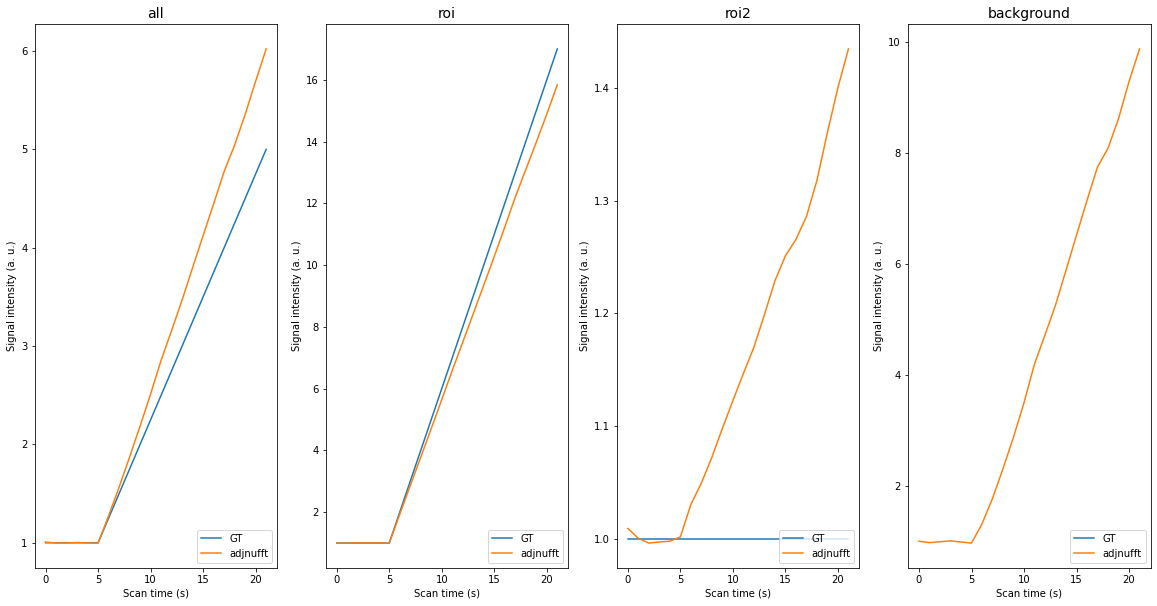

In [53]:
dcomp_trivial = torch.ones(dcomp.shape).to(device)

CG_recon, nufft_recon = \
RadialRecon_alternative(kspace= kspace.to(device), 
            traj = traj.to(device), 
            coil_sensitivities= (2 ** (-0.5)) * torch.ones((1, 1, 2, x, y), dtype = torch.float32).to(device), 
            #w = dcomp.to(device), 
            w = dcomp_trivial.to(device), 
            grid_size = (640, 640),
            im_size = (320, 320), 
            tolerance = 1e-10,
            lambda1 = None,
            niter = 128,
            optimizer = 'CG5')

CG_recon_complex = CG_recon[:,0] + 1j * CG_recon[:,0]

plotcoil(np.abs(CG_recon_complex))
plotcurves(x_hat = np.abs(CG_recon_complex), 
           x_gt = pt.cpu(). numpy(), 
           maskdict = maskdict,
           names = ['adjnufft', 'GT'], 
           normalize = True)

0 alpha:  tensor([ 1.2297e-01, -2.5922e-09], device='cuda:0')
1 alpha:  tensor([ 3.5932e-01, -5.6013e-09], device='cuda:0')
2 alpha:  tensor([ 6.4819e-01, -3.1925e-08], device='cuda:0')
3 alpha:  tensor([ 8.3621e-01, -1.6002e-08], device='cuda:0')
4 alpha:  tensor([ 1.3689e-01, -3.1411e-09], device='cuda:0')
5 alpha:  tensor([ 8.7139e-01, -2.5734e-08], device='cuda:0')
6 alpha:  tensor([ 6.8817e-01, -2.6527e-08], device='cuda:0')
7 alpha:  tensor([ 6.7225e-01, -2.2238e-08], device='cuda:0')
8 alpha:  tensor([ 1.6883e-01, -3.5872e-09], device='cuda:0')
9 alpha:  tensor([ 7.0616e-01, -1.9833e-08], device='cuda:0')
10 alpha:  tensor([ 6.3775e-01, -1.5276e-08], device='cuda:0')
11 alpha:  tensor([ 1.1357e+00, -2.5651e-08], device='cuda:0')
12 alpha:  tensor([ 3.5307e-01, -7.2351e-09], device='cuda:0')
13 alpha:  tensor([ 4.6483e-01, -1.1562e-08], device='cuda:0')
14 alpha:  tensor([ 8.2168e-01, -1.3813e-08], device='cuda:0')
15 alpha:  tensor([ 1.3536e+00, -3.7658e-08], device='cuda:0')
16

130 alpha:  tensor([ 5.0314e-01, -1.4489e-08], device='cuda:0')
131 alpha:  tensor([ 7.8522e-01, -1.8725e-08], device='cuda:0')
132 alpha:  tensor([ 1.5013e+00, -2.8292e-08], device='cuda:0')
133 alpha:  tensor([ 9.9756e-01, -3.4726e-08], device='cuda:0')
134 alpha:  tensor([ 1.9173e-01, -1.3987e-08], device='cuda:0')
135 alpha:  tensor([ 8.6267e-01, -1.4457e-08], device='cuda:0')
136 alpha:  tensor([ 1.1017e+00, -2.9316e-08], device='cuda:0')
137 alpha:  tensor([ 5.9644e-01, -8.4874e-09], device='cuda:0')
138 alpha:  tensor([ 1.2436e+00, -2.7752e-08], device='cuda:0')
139 alpha:  tensor([ 1.9237e-01, -6.2215e-09], device='cuda:0')
140 alpha:  tensor([ 7.4472e-01, -2.1137e-08], device='cuda:0')
141 alpha:  tensor([ 1.2295e+00, -3.3584e-08], device='cuda:0')
142 alpha:  tensor([ 1.2921e+00, -3.2268e-08], device='cuda:0')
143 alpha:  tensor([ 3.6669e-01, -9.0237e-09], device='cuda:0')
144 alpha:  tensor([ 3.4779e-01, -8.3742e-09], device='cuda:0')
145 alpha:  tensor([ 6.5610e-01, -1.7057

259 alpha:  tensor([ 1.1971e+00, -3.6293e-08], device='cuda:0')
260 alpha:  tensor([ 6.0348e-01, -1.7071e-08], device='cuda:0')
261 alpha:  tensor([ 2.8023e-01, -2.9829e-09], device='cuda:0')
262 alpha:  tensor([ 4.7906e-01, -1.2842e-08], device='cuda:0')
263 alpha:  tensor([ 1.5777e+00, -4.2607e-08], device='cuda:0')
264 alpha:  tensor([ 1.1678e+00, -3.1367e-08], device='cuda:0')
265 alpha:  tensor([ 6.7064e-01, -1.6270e-08], device='cuda:0')
266 alpha:  tensor([ 2.4616e-01, -2.0321e-09], device='cuda:0')
267 alpha:  tensor([ 7.6104e-01, -2.0356e-08], device='cuda:0')
268 alpha:  tensor([ 8.0111e-01, -2.1150e-08], device='cuda:0')
269 alpha:  tensor([ 1.0054e+00, -2.4986e-08], device='cuda:0')
270 alpha:  tensor([ 1.0097e+00, -2.9366e-08], device='cuda:0')
271 alpha:  tensor([ 2.1904e-01, -1.2992e-09], device='cuda:0')
272 alpha:  tensor([ 9.7824e-01, -2.5214e-08], device='cuda:0')
273 alpha:  tensor([ 1.3154e+00, -3.2989e-08], device='cuda:0')
274 alpha:  tensor([ 8.1324e-01, -4.2169

388 alpha:  tensor([ 2.4065e-01, -1.3634e-08], device='cuda:0')
389 alpha:  tensor([ 1.0093e+00, -6.1007e-09], device='cuda:0')
390 alpha:  tensor([ 6.3118e-01, -2.4444e-08], device='cuda:0')
391 alpha:  tensor([ 1.2957e+00, -4.0296e-08], device='cuda:0')
392 alpha:  tensor([4.9787e-01, 3.0143e-09], device='cuda:0')
393 alpha:  tensor([ 3.5418e-01, -1.3463e-08], device='cuda:0')
394 alpha:  tensor([ 1.2184e+00, -3.4724e-08], device='cuda:0')
395 alpha:  tensor([ 1.2208e+00, -2.2901e-08], device='cuda:0')
396 alpha:  tensor([ 7.1597e-01, -3.0543e-08], device='cuda:0')
397 alpha:  tensor([ 4.4483e-01, -2.7712e-08], device='cuda:0')
398 alpha:  tensor([2.7748e-01, 9.4156e-10], device='cuda:0')
399 alpha:  tensor([ 1.1543e+00, -3.1805e-08], device='cuda:0')
400 alpha:  tensor([ 1.4452e+00, -2.4104e-08], device='cuda:0')
401 alpha:  tensor([ 8.9944e-01, -1.9270e-08], device='cuda:0')
402 alpha:  tensor([ 2.1340e-01, -9.9267e-09], device='cuda:0')
403 alpha:  tensor([ 6.9245e-01, -1.2488e-08

517 alpha:  tensor([1.3167e+00, 1.5364e-08], device='cuda:0')
518 alpha:  tensor([ 1.1926e+00, -4.7118e-08], device='cuda:0')
519 alpha:  tensor([ 2.2360e-01, -2.2529e-08], device='cuda:0')
520 alpha:  tensor([7.1200e-01, 1.2934e-08], device='cuda:0')
521 alpha:  tensor([ 7.2199e-01, -3.6971e-08], device='cuda:0')
522 alpha:  tensor([0.8896, -0.0000], device='cuda:0')
523 alpha:  tensor([ 1.2419e+00, -2.3636e-08], device='cuda:0')
524 alpha:  tensor([ 3.8991e-01, -6.3729e-09], device='cuda:0')
525 alpha:  tensor([ 3.7031e-01, -1.4917e-08], device='cuda:0')
526 alpha:  tensor([ 1.1963e+00, -1.1489e-08], device='cuda:0')
527 alpha:  tensor([ 1.3344e+00, -9.5429e-09], device='cuda:0')
528 alpha:  tensor([ 7.6686e-01, -5.2240e-08], device='cuda:0')
529 alpha:  tensor([3.2528e-01, 1.8152e-08], device='cuda:0')
530 alpha:  tensor([ 3.4420e-01, -2.7202e-08], device='cuda:0')
531 alpha:  tensor([ 1.3272e+00, -6.2804e-08], device='cuda:0')
532 alpha:  tensor([1.0575e+00, 1.1546e-08], device='cu

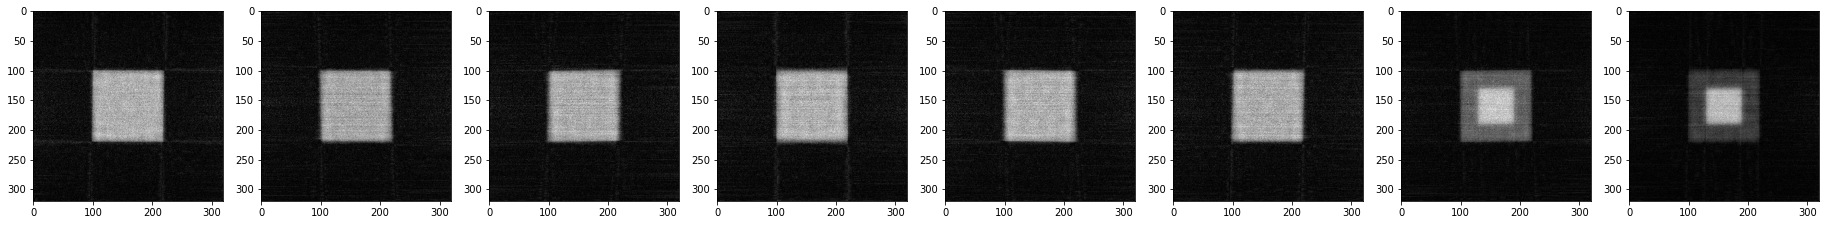

(22,)


../radialmri/simulation_and_reconstruction.py:226: RuntimeWarning: invalid value encountered in true_divide
  return curve/m;


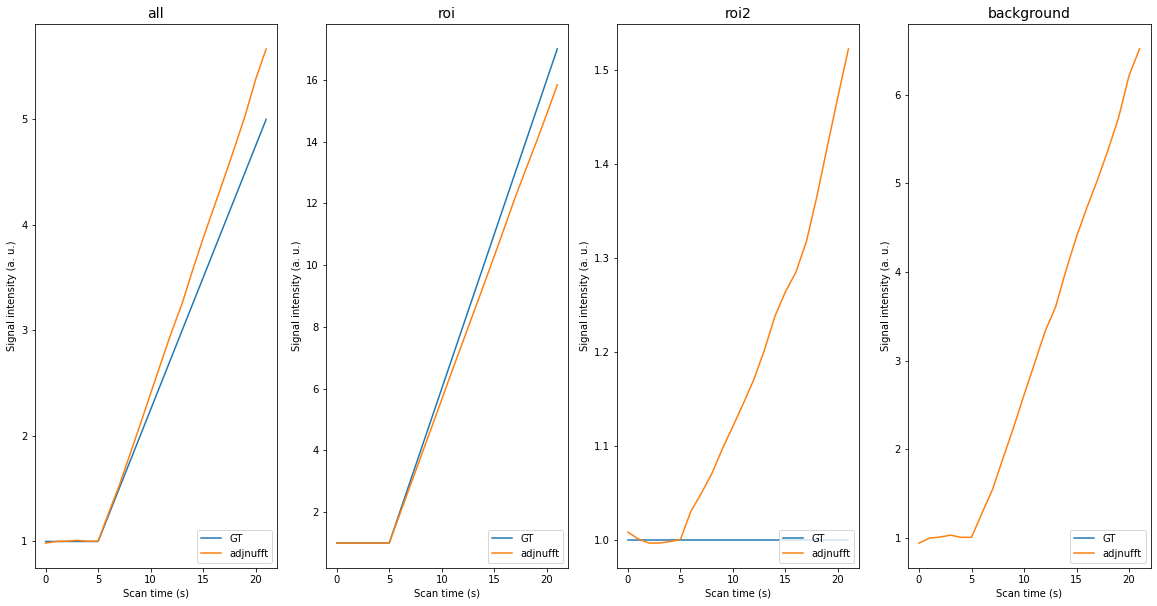

In [54]:
dcomp_trivial = torch.ones(dcomp.shape).to(device)

CG_recon, nufft_recon = \
RadialRecon_alternative(kspace= kspace.to(device), 
            traj = traj.to(device), 
            coil_sensitivities= (2 ** (-0.5)) * torch.ones((1, 1, 2, x, y), dtype = torch.float32).to(device), 
            #w = dcomp.to(device), 
            w = dcomp_trivial.to(device), 
            grid_size = (640, 640),
            im_size = (320, 320), 
            tolerance = 1e-10,
            lambda1 = None,
            niter = 640,
            optimizer = 'CG5')

CG_recon_complex = CG_recon[:,0] + 1j * CG_recon[:,0]

plotcoil(np.abs(CG_recon_complex))
plotcurves(x_hat = np.abs(CG_recon_complex), 
           x_gt = pt.cpu(). numpy(), 
           maskdict = maskdict,
           names = ['adjnufft', 'GT'], 
           normalize = True)

In [8]:
# 3. 0 Multi-coil simulation with naive coil sensitivities

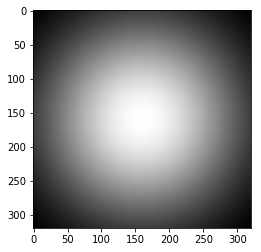

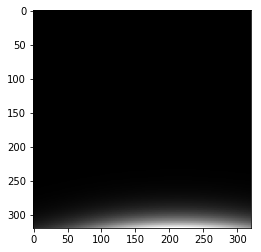

0.0037569998187905185 2.8982654423930647
-0.024265338123475644 -0.08970234511895514
-0.2682726615325457 -1.9478907695074703
1.0390832232153873 -0.7036198680433765
2.112871648533609 1.5259042857047769
0.32668324272787164 0.20978372153181546
2.2943015349368148 -2.6924920769410328
-1.452092419917954 -1.1920715390353442
0.5713393156101585 -0.06373461365326616
2.492568382560618 0.09370179996805295
-2.630167022542887 -0.21270787424162663
2.20664789271315 -2.4771642384162744
-0.5039515193413728 -0.699765554586953
2.1176887047863264 -1.2677770090132232
-1.5278968836514817 -2.2203797702962604
1.6104943554552813 -1.0636711224236253


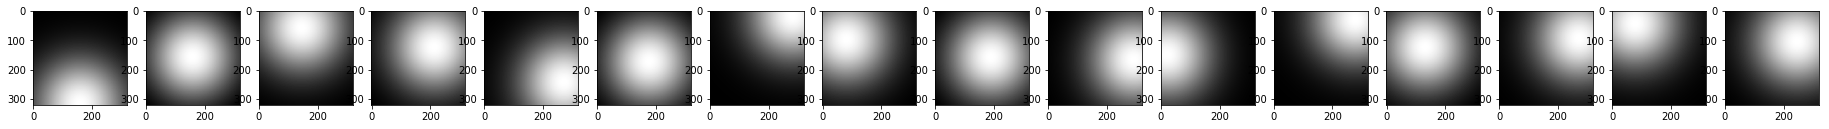

(16, 320, 320) complex128 torch.Size([22, 2, 320, 320])


In [49]:
def coil_smap_sim(h, w, x0 = 0, y0 = 0):
    #https://www.geeksforgeeks.org/how-to-generate-2-d-gaussian-array-using-numpy/
    # Initializing value of x-axis and y-axis
    # in the range -2 to +2
    x, y = np.meshgrid(np.linspace(-3, 3, h), np.linspace(-3, 3, w))
    dst = np.sqrt(x**2 + y**2)

    # Intializing sigma and muu
    sigma_x, sigma_y = 2.0, 2.0 * h / w

    # Calculating Gaussian array
    gauss = np.exp(-( (x - x0)**2 / ( 2.0 * sigma_x**2 ) \
                    + (y - y0)**2 / ( 2.0 * sigma_y**2 ) ) )
    
    return gauss

def multi_coil_smap_sim(h, w, ncoil = 16):
    res = []
    for i in range(ncoil):
        x0, y0 = np.random.uniform(-3, 3, size = 2)
        print(x0, y0)
        res.append(coil_smap_sim(h, w, x0, y0))
        
    return np.array(res)

gauss = coil_smap_sim(320, 320)

plt.imshow(gauss)
plt.show()

gauss = coil_smap_sim(320, 320, 1, 16)

plt.imshow(gauss)
plt.show()

smap = multi_coil_smap_sim(320, 320, ncoil = 16)

plotcoil(x = smap, n = 16)

smap = smap + 1j * smap
print(smap.shape, smap.dtype, pt.shape)

smap_tensor = numpy2torch(smap).permute(1, 0, 2, 3).unsqueeze(0).to(torch.float32).to(device)

/gpfs/share/apps/anaconda3/gpu/5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


torch.Size([22, 1, 2, 13440])
torch.Size([22, 16, 2, 13440])
torch.Size([22, 2, 320, 320])


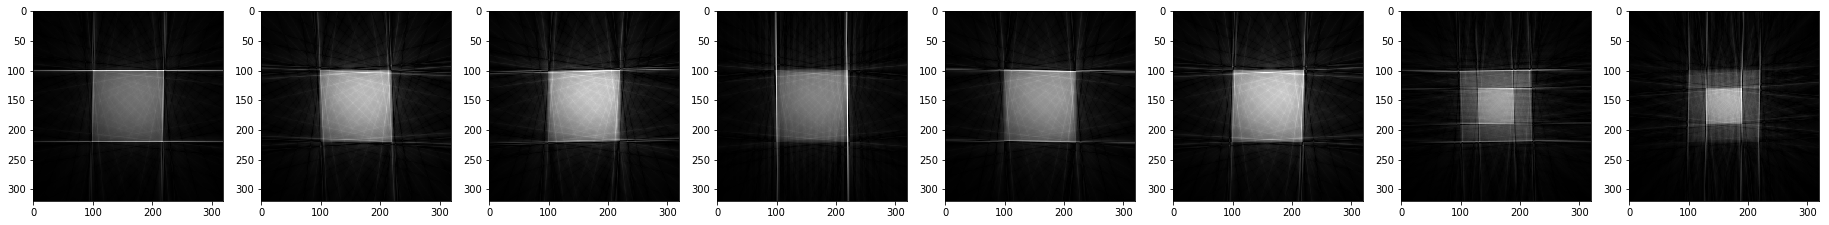

(22,)


../radialmri/simulation_and_reconstruction.py:227: RuntimeWarning: invalid value encountered in true_divide
  return curve/m;


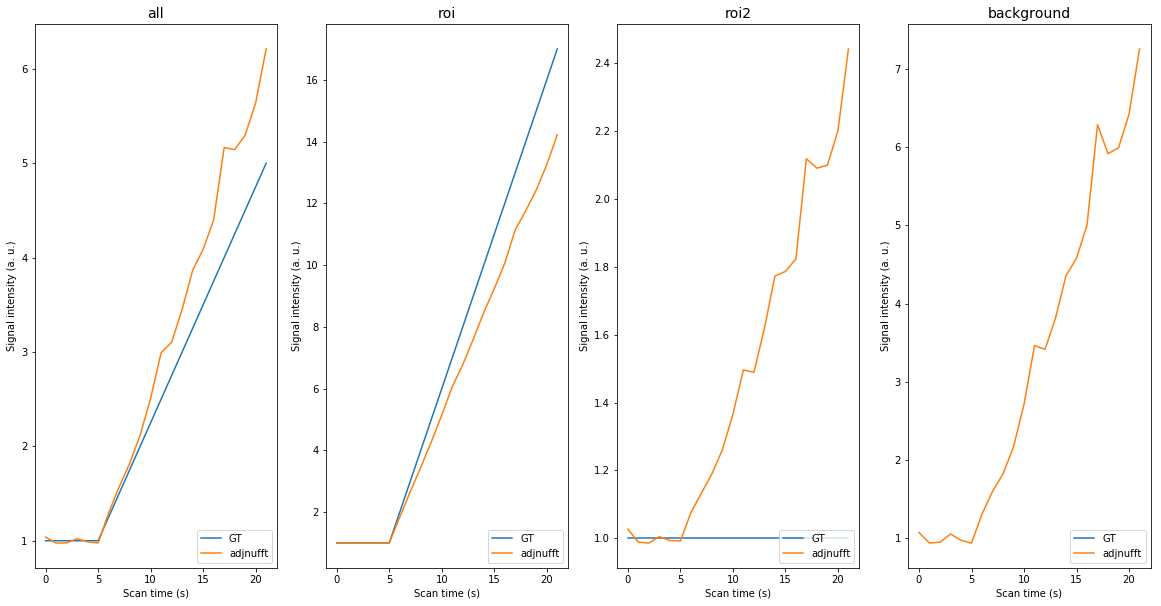

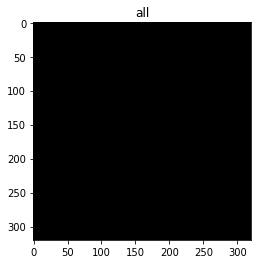

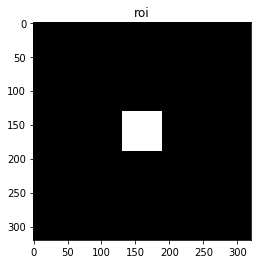

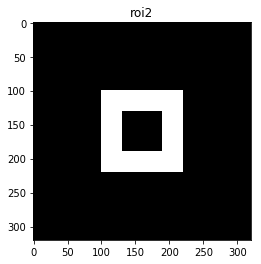

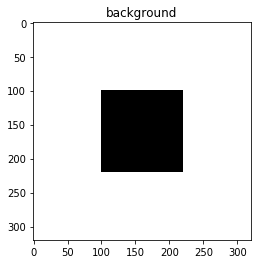

In [50]:
kspace_mc, recon_mc, traj_mc, dcomp_mc = RadialSimulation(target= torch.tensor(pt, dtype = torch.float32).to(device), 
                                                 spokespertime= 21, nt= 22, nc = 1, spokelength= 640, 
                                                 #smap= (2 ** (-0.5)) * torch.ones((1, 1, 2, x, y) , dtype = torch.float32).to(device),
                                                 smap = smap_tensor,
                                                 grid_size= (640, 640), im_size= (320, 320))

plotcoil(torch.sqrt(recon_mc[:, 0]**2 + recon_mc[:, 1]**2).cpu(), n = 8)

plotcurves(x_hat = recon_mc.cpu(). numpy(), 
           x_gt = pt.cpu(). numpy(), 
           maskdict = maskdict,
           names = ['adjnufft', 'GT'], 
           normalize = True)

for k, v in maskdict.items():
    #plt.imshow(v, vmin = 0, vmax = 1)
    plt.imshow(v)
    plt.title(k)
    plt.show()

In [11]:
numpy2torch(smap).permute(1, 0, 2, 3).unsqueeze(0).shape

torch.Size([1, 16, 2, 320, 320])

0 alpha:  tensor([ 1.7966e-02, -6.7145e-10], device='cuda:0')


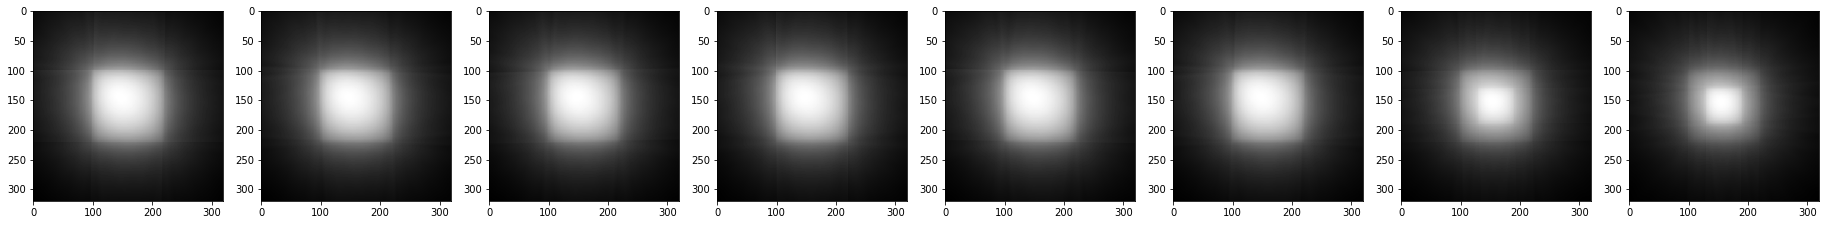

(22,)


../radialmri/simulation_and_reconstruction.py:227: RuntimeWarning: invalid value encountered in true_divide
  return curve/m;


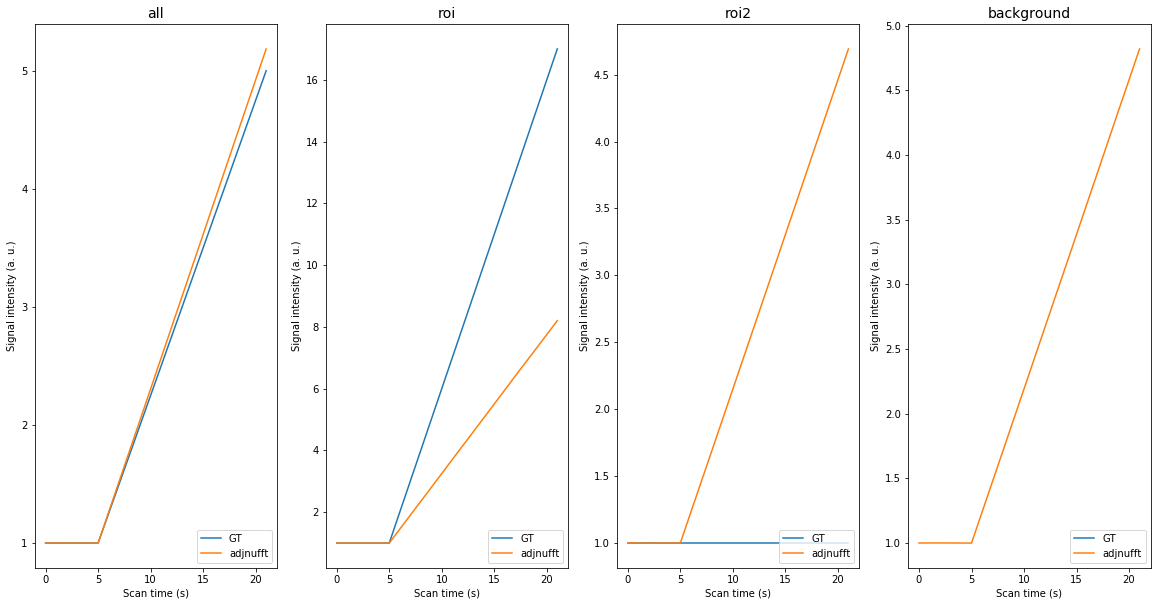

In [12]:
# CG5, no dcomp, 1 iterations
dcomp_trivial = torch.ones(dcomp.shape).to(device)

CG_recon_mc, nufft_recon_mc = \
RadialRecon_alternative(kspace= kspace_mc.to(device), 
            traj = traj_mc.to(device), 
            coil_sensitivities= smap_tensor, 
            w = dcomp_trivial.to(device), 
            #w = dcomp.to(device), 
            grid_size = (640, 640),
            im_size = (320, 320), 
            tolerance = 1e-10,
            lambda1 = None,
            niter = 1,
            optimizer = 'CG5')

CG_recon_complex_mc = CG_recon_mc[:,0] + 1j * CG_recon_mc[:,0]

plotcoil(np.abs(CG_recon_complex_mc))

plotcurves(x_hat = np.abs(CG_recon_complex_mc), 
           x_gt = pt.cpu(). numpy(), 
           maskdict = maskdict,
           names = ['adjnufft', 'GT'], 
           normalize = True)

0 alpha:  tensor([ 1.7966e-02, -6.9760e-10], device='cuda:0')
1 alpha:  tensor([ 3.8356e-02, -1.8271e-09], device='cuda:0')
2 alpha:  tensor([ 4.2323e-02, -2.0038e-09], device='cuda:0')
3 alpha:  tensor([ 5.8662e-02, -1.7628e-09], device='cuda:0')
4 alpha:  tensor([ 6.6949e-02, -2.1054e-09], device='cuda:0')
5 alpha:  tensor([ 8.1064e-02, -2.6019e-09], device='cuda:0')
6 alpha:  tensor([ 3.0365e-02, -1.4185e-09], device='cuda:0')
7 alpha:  tensor([ 4.3655e-02, -1.6404e-09], device='cuda:0')
8 alpha:  tensor([ 9.9233e-02, -3.7310e-09], device='cuda:0')
9 alpha:  tensor([ 1.2019e-01, -2.9888e-09], device='cuda:0')
10 alpha:  tensor([ 6.7827e-02, -2.3784e-09], device='cuda:0')
11 alpha:  tensor([ 6.7226e-02, -2.3850e-09], device='cuda:0')
12 alpha:  tensor([ 3.5281e-02, -1.3253e-09], device='cuda:0')
13 alpha:  tensor([ 8.4741e-02, -2.1338e-09], device='cuda:0')
14 alpha:  tensor([ 1.4917e-01, -5.4059e-09], device='cuda:0')
15 alpha:  tensor([ 8.0307e-02, -2.6771e-09], device='cuda:0')
16

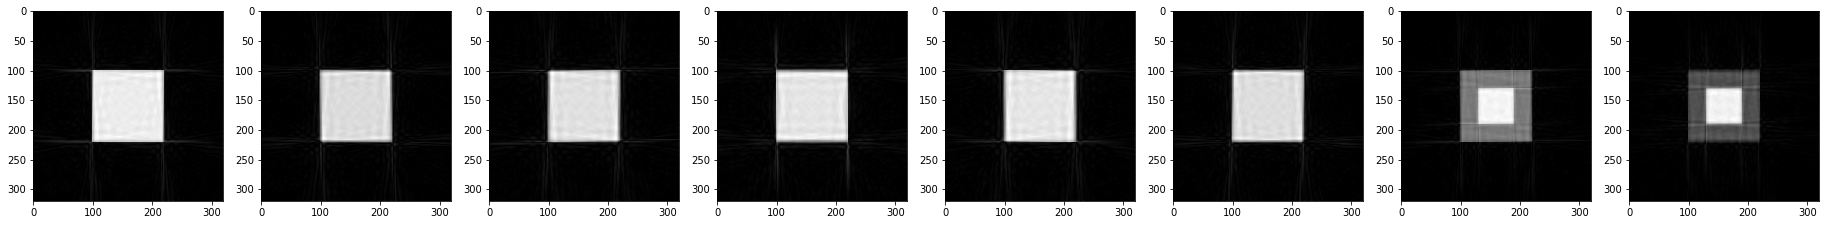

(22,)


../radialmri/simulation_and_reconstruction.py:227: RuntimeWarning: invalid value encountered in true_divide
  return curve/m;


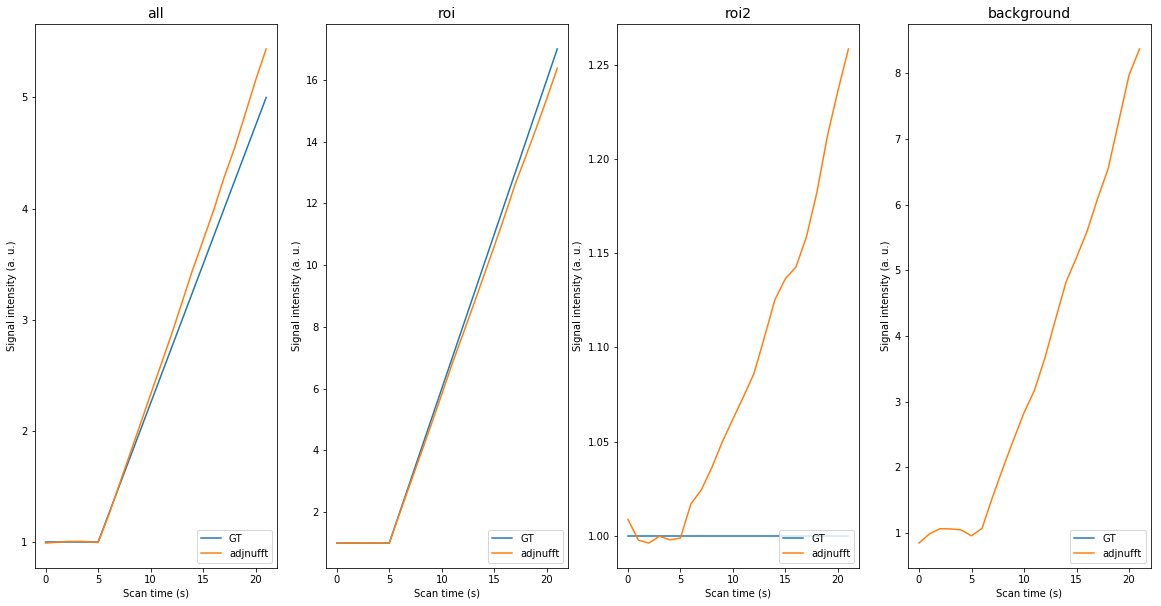

In [13]:
# CG5, no dcomp, 32 iterations
dcomp_trivial = torch.ones(dcomp.shape).to(device)

CG_recon_mc, nufft_recon_mc = \
RadialRecon_alternative(kspace= kspace_mc.to(device), 
            traj = traj_mc.to(device), 
            coil_sensitivities= smap_tensor, 
            w = dcomp_trivial.to(device), 
            #w = dcomp.to(device), 
            grid_size = (640, 640),
            im_size = (320, 320), 
            tolerance = 1e-10,
            lambda1 = None,
            niter = 32,
            optimizer = 'CG5')

CG_recon_complex_mc = CG_recon_mc[:,0] + 1j * CG_recon_mc[:,0]

plotcoil(np.abs(CG_recon_complex_mc))

plotcurves(x_hat = np.abs(CG_recon_complex_mc), 
           x_gt = pt.cpu(). numpy(), 
           maskdict = maskdict,
           names = ['adjnufft', 'GT'], 
           normalize = True)

0 alpha:  tensor([ 2.1854e+00, -4.9408e-08], device='cuda:0')
1 alpha:  tensor([ 5.6169e-01, -1.7529e-08], device='cuda:0')
2 alpha:  tensor([ 5.8167e-01, -9.1753e-09], device='cuda:0')
3 alpha:  tensor([ 6.7573e-01, -9.1536e-09], device='cuda:0')
4 alpha:  tensor([ 6.6966e-01, -1.5519e-08], device='cuda:0')
5 alpha:  tensor([ 5.7563e-01, -1.5990e-08], device='cuda:0')
6 alpha:  tensor([ 6.0329e-01, -1.7099e-08], device='cuda:0')
7 alpha:  tensor([ 6.1350e-01, -1.0627e-08], device='cuda:0')
8 alpha:  tensor([ 5.8603e-01, -1.5904e-08], device='cuda:0')
9 alpha:  tensor([ 6.4053e-01, -1.6098e-08], device='cuda:0')
10 alpha:  tensor([ 7.9068e-01, -1.4922e-08], device='cuda:0')
11 alpha:  tensor([ 8.7549e-01, -2.0371e-08], device='cuda:0')
12 alpha:  tensor([ 8.4758e-01, -1.2763e-08], device='cuda:0')
13 alpha:  tensor([ 8.2921e-01, -1.2923e-08], device='cuda:0')
14 alpha:  tensor([ 8.7407e-01, -1.6523e-08], device='cuda:0')
15 alpha:  tensor([ 9.2839e-01, -1.8293e-08], device='cuda:0')
16

130 alpha:  tensor([ 9.5666e-01, -9.1453e-10], device='cuda:0')
131 alpha:  tensor([ 9.7365e-01, -5.4762e-09], device='cuda:0')
132 alpha:  tensor([ 9.4636e-01, -5.9284e-09], device='cuda:0')
133 alpha:  tensor([ 9.2866e-01, -3.1048e-09], device='cuda:0')
134 alpha:  tensor([ 9.4778e-01, -4.2403e-09], device='cuda:0')
135 alpha:  tensor([ 9.6510e-01, -4.4667e-09], device='cuda:0')
136 alpha:  tensor([ 9.6088e-01, -5.0161e-09], device='cuda:0')
137 alpha:  tensor([ 9.6674e-01, -7.3140e-09], device='cuda:0')
138 alpha:  tensor([ 9.5468e-01, -5.6088e-09], device='cuda:0')
139 alpha:  tensor([ 9.2897e-01, -5.1012e-09], device='cuda:0')
140 alpha:  tensor([ 9.4730e-01, -6.3930e-09], device='cuda:0')
141 alpha:  tensor([ 9.5997e-01, -8.4451e-09], device='cuda:0')
142 alpha:  tensor([ 9.6576e-01, -6.0739e-09], device='cuda:0')
143 alpha:  tensor([ 9.5375e-01, -4.7972e-09], device='cuda:0')
144 alpha:  tensor([ 8.9957e-01, -7.1889e-09], device='cuda:0')
145 alpha:  tensor([ 8.3005e-01, -1.2429

259 alpha:  tensor([ 9.1958e-01, -7.4363e-09], device='cuda:0')
260 alpha:  tensor([ 8.9266e-01, -9.8477e-09], device='cuda:0')
261 alpha:  tensor([ 8.6407e-01, -1.4958e-08], device='cuda:0')
262 alpha:  tensor([ 8.6082e-01, -1.3852e-08], device='cuda:0')
263 alpha:  tensor([ 8.8822e-01, -8.7498e-09], device='cuda:0')
264 alpha:  tensor([ 9.3001e-01, -1.0879e-08], device='cuda:0')
265 alpha:  tensor([9.3602e-01, 3.7503e-10], device='cuda:0')
266 alpha:  tensor([ 9.4522e-01, -2.7294e-09], device='cuda:0')
267 alpha:  tensor([ 9.5265e-01, -5.7270e-09], device='cuda:0')
268 alpha:  tensor([9.6874e-01, 8.3998e-10], device='cuda:0')
269 alpha:  tensor([ 9.5828e-01, -2.2884e-09], device='cuda:0')
270 alpha:  tensor([ 9.4500e-01, -1.6059e-09], device='cuda:0')
271 alpha:  tensor([ 9.5049e-01, -8.4175e-10], device='cuda:0')
272 alpha:  tensor([ 9.6957e-01, -3.4918e-09], device='cuda:0')
273 alpha:  tensor([ 9.6535e-01, -7.8634e-10], device='cuda:0')
274 alpha:  tensor([ 9.5288e-01, -2.9395e-09

388 alpha:  tensor([ 9.5023e-01, -3.7845e-09], device='cuda:0')
389 alpha:  tensor([ 9.5905e-01, -7.7833e-09], device='cuda:0')
390 alpha:  tensor([ 9.4249e-01, -1.1764e-09], device='cuda:0')
391 alpha:  tensor([ 9.6042e-01, -1.5261e-09], device='cuda:0')
392 alpha:  tensor([ 9.5292e-01, -1.0518e-08], device='cuda:0')
393 alpha:  tensor([9.3600e-01, 5.4735e-10], device='cuda:0')
394 alpha:  tensor([ 9.1842e-01, -8.8039e-09], device='cuda:0')
395 alpha:  tensor([ 8.7901e-01, -1.6463e-08], device='cuda:0')
396 alpha:  tensor([ 8.6423e-01, -9.5295e-09], device='cuda:0')
397 alpha:  tensor([ 8.7550e-01, -9.2975e-09], device='cuda:0')
398 alpha:  tensor([ 9.0172e-01, -1.3103e-08], device='cuda:0')
399 alpha:  tensor([ 9.3272e-01, -4.1714e-09], device='cuda:0')
400 alpha:  tensor([ 9.3149e-01, -7.0393e-09], device='cuda:0')
401 alpha:  tensor([ 9.0140e-01, -1.0974e-08], device='cuda:0')
402 alpha:  tensor([ 8.4580e-01, -1.4518e-08], device='cuda:0')
403 alpha:  tensor([ 7.7043e-01, -1.5121e-

517 alpha:  tensor([ 9.6196e-01, -6.7010e-09], device='cuda:0')
518 alpha:  tensor([9.6371e-01, 1.8027e-09], device='cuda:0')
519 alpha:  tensor([ 9.5053e-01, -6.9991e-09], device='cuda:0')
520 alpha:  tensor([ 9.4720e-01, -4.3458e-09], device='cuda:0')
521 alpha:  tensor([ 9.4115e-01, -1.5203e-09], device='cuda:0')
522 alpha:  tensor([ 8.8495e-01, -1.1672e-08], device='cuda:0')
523 alpha:  tensor([ 7.9947e-01, -1.2396e-08], device='cuda:0')
524 alpha:  tensor([ 7.6560e-01, -1.1677e-08], device='cuda:0')
525 alpha:  tensor([ 8.4299e-01, -6.7891e-09], device='cuda:0')
526 alpha:  tensor([ 9.1346e-01, -4.7364e-09], device='cuda:0')
527 alpha:  tensor([ 9.3945e-01, -3.5641e-09], device='cuda:0')
528 alpha:  tensor([ 9.5392e-01, -1.8780e-09], device='cuda:0')
529 alpha:  tensor([ 9.3971e-01, -7.8225e-09], device='cuda:0')
530 alpha:  tensor([ 8.9409e-01, -1.2479e-08], device='cuda:0')
531 alpha:  tensor([ 8.7563e-01, -1.2083e-08], device='cuda:0')
532 alpha:  tensor([ 8.6434e-01, -1.6454e-

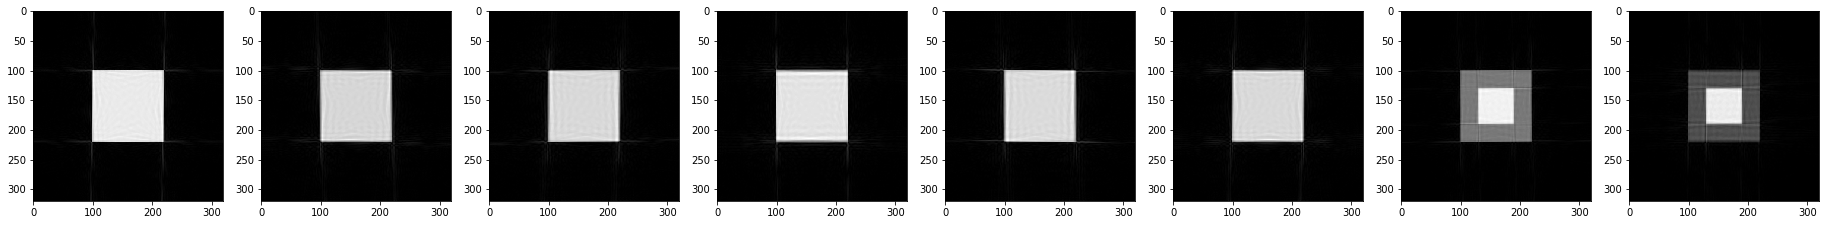

(22,)


../radialmri/simulation_and_reconstruction.py:227: RuntimeWarning: invalid value encountered in true_divide
  return curve/m;


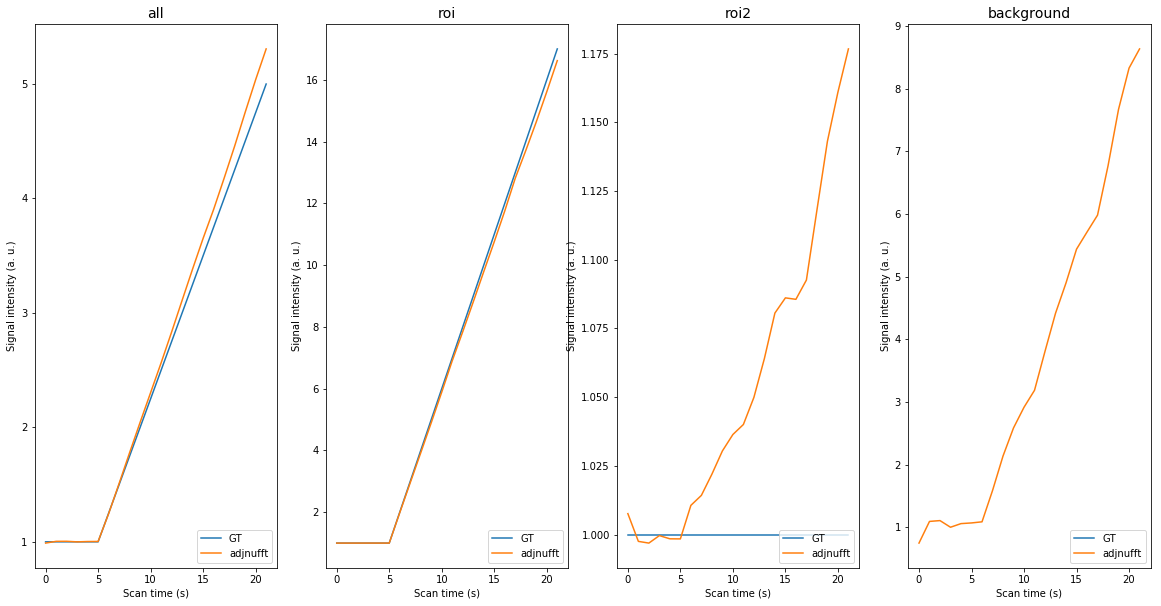

In [14]:
# CG5, with dcomp, 640 iterations
dcomp_trivial = torch.ones(dcomp.shape).to(device)

CG_recon_mc, nufft_recon_mc = \
RadialRecon_alternative(kspace= kspace_mc.to(device), 
            traj = traj_mc.to(device), 
            coil_sensitivities= smap_tensor, 
            #w = dcomp_trivial.to(device), 
            w = dcomp.to(device), 
            grid_size = (640, 640),
            im_size = (320, 320), 
            tolerance = 1e-10,
            lambda1 = None,
            niter = 640,
            optimizer = 'CG5')

CG_recon_complex_mc = CG_recon_mc[:,0] + 1j * CG_recon_mc[:,0]

plotcoil(np.abs(CG_recon_complex_mc))

plotcurves(x_hat = np.abs(CG_recon_complex_mc), 
           x_gt = pt.cpu(). numpy(), 
           maskdict = maskdict,
           names = ['adjnufft', 'GT'], 
           normalize = True)

## Using different density compensation.

In [46]:
def dcomp_reference(traj, nt = 22, nc = 1):
    dcomp = torch.sqrt(traj[0, 0]**2 + traj[0, 1]**2)
    dcomp = dcomp / max(dcomp)
    dcomp = dcomp.repeat(nt, nc, 2, 1)
    return dcomp
    #print(dcomp.shape)

dcomp_FL = dcomp_reference(traj, nt = 22, nc = 16)
print(dcomp_FL.shape, dcomp_FL.device)

torch.Size([22, 16, 2, 13440]) cpu


torch.Size([22, 2, 320, 320])


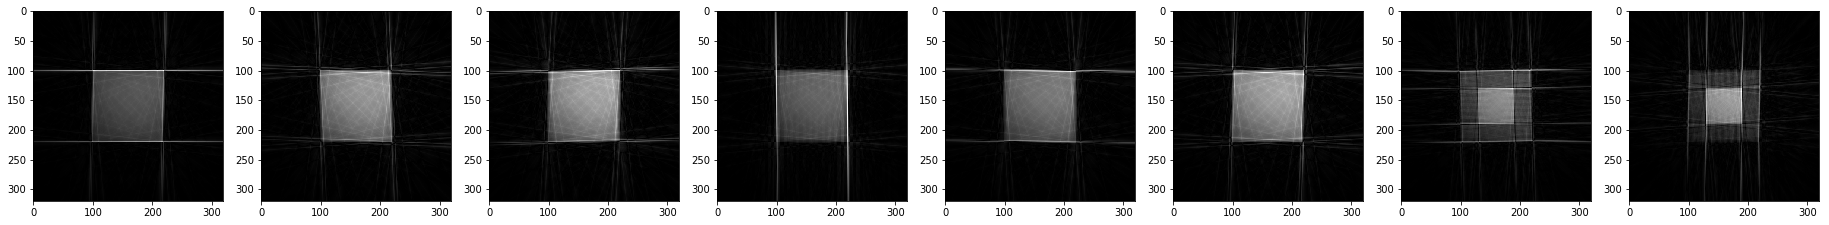

(22,)


../radialmri/simulation_and_reconstruction.py:227: RuntimeWarning: invalid value encountered in true_divide
  return curve/m;


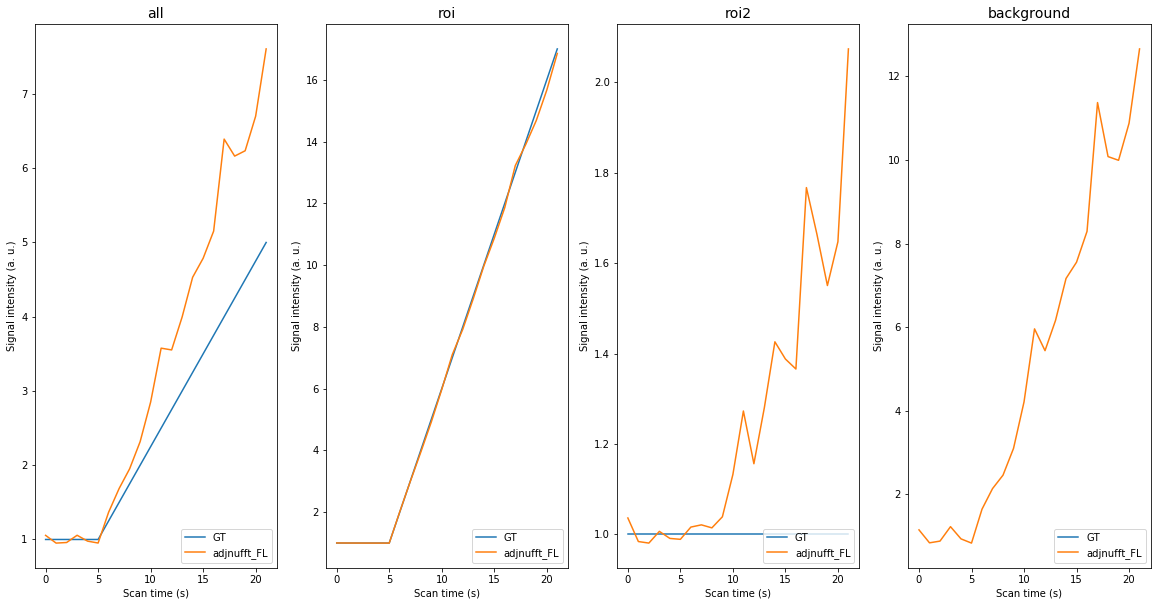

In [51]:
radialmodel = RadialModel(grid_size= (640, 640), im_size= (320, 320)).to(device, dtype)
adj_nufft_FLdcomp = radialmodel.adjoint(y = kspace_mc.to(device) * torch.sqrt(dcomp_FL.to(device)),
                    k = traj.to(device), 
                    coil_sensitivities = smap_tensor, 
                    w = dcomp_FL.to(device))

print(adj_nufft_FLdcomp.shape)
adjnufft_FLdcom = torch.sqrt(adj_nufft_FLdcomp[:, 0]**2 + adj_nufft_FLdcomp[:, 1]**2).cpu()
plotcoil(adjnufft_FLdcom)

plotcurves(x_hat = np.abs(adj_nufft_FLdcomp.cpu().numpy()), 
           x_gt = pt.cpu(). numpy(), 
           maskdict = maskdict,
           names = ['adjnufft_FL', 'GT'], 
           normalize = True)

0 alpha:  tensor([ 1.6049e+00, -2.3720e-08], device='cuda:0')
1 alpha:  tensor([ 5.2762e-01, -1.4594e-08], device='cuda:0')
2 alpha:  tensor([ 4.5552e-01, -3.8949e-09], device='cuda:0')
3 alpha:  tensor([ 4.7646e-01, -5.2053e-09], device='cuda:0')
4 alpha:  tensor([ 4.7710e-01, -5.2800e-09], device='cuda:0')
5 alpha:  tensor([ 4.5193e-01, -8.8357e-09], device='cuda:0')
6 alpha:  tensor([ 4.9809e-01, -7.9419e-09], device='cuda:0')
7 alpha:  tensor([ 5.4383e-01, -8.6887e-09], device='cuda:0')
8 alpha:  tensor([ 5.1809e-01, -1.0972e-08], device='cuda:0')
9 alpha:  tensor([ 4.9333e-01, -9.7860e-09], device='cuda:0')
10 alpha:  tensor([ 5.4643e-01, -8.9021e-09], device='cuda:0')
11 alpha:  tensor([ 6.4732e-01, -7.5643e-09], device='cuda:0')
12 alpha:  tensor([ 7.4026e-01, -8.1974e-09], device='cuda:0')
13 alpha:  tensor([ 8.0533e-01, -1.2773e-08], device='cuda:0')
14 alpha:  tensor([ 8.2517e-01, -1.7275e-08], device='cuda:0')
15 alpha:  tensor([ 7.9888e-01, -1.2605e-08], device='cuda:0')
16

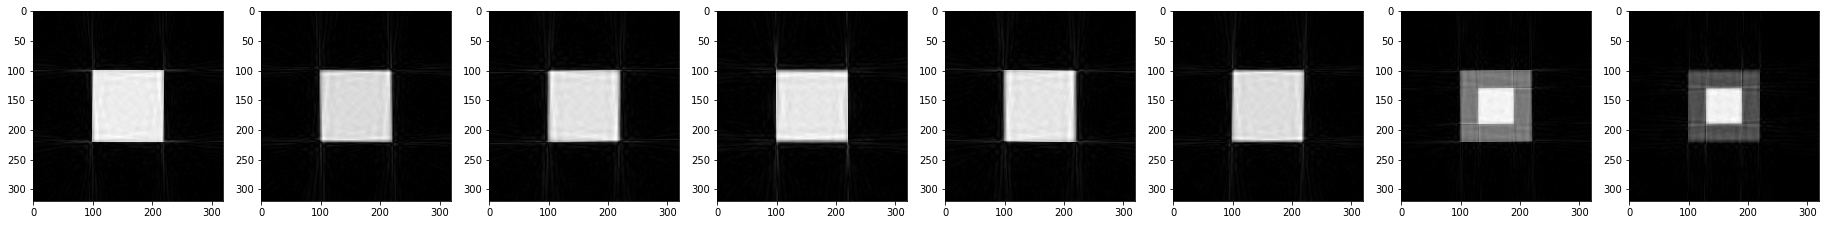

(22,)


../radialmri/simulation_and_reconstruction.py:227: RuntimeWarning: invalid value encountered in true_divide
  return curve/m;


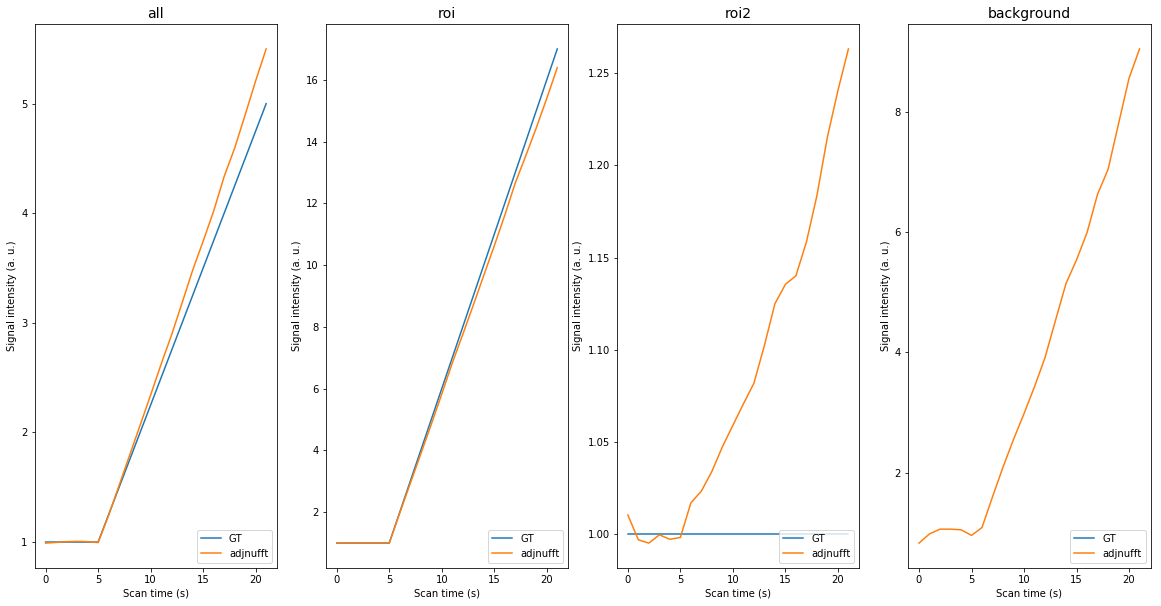

In [52]:
CG_recon_mc, nufft_recon_mc = \
RadialRecon_alternative(kspace= kspace_mc.to(device), 
            traj = traj_mc.to(device), 
            coil_sensitivities= smap_tensor, 
            w = dcomp_FL.to(device), 
            grid_size = (640, 640),
            im_size = (320, 320), 
            tolerance = 1e-10,
            lambda1 = None,
            niter = 32,
            optimizer = 'CG5')

CG_recon_complex_mc = CG_recon_mc[:,0] + 1j * CG_recon_mc[:,0]

plotcoil(np.abs(CG_recon_complex_mc))

plotcurves(x_hat = np.abs(CG_recon_complex_mc), 
           x_gt = pt.cpu(). numpy(), 
           maskdict = maskdict,
           names = ['adjnufft', 'GT'], 
           normalize = True)

0 alpha:  tensor([ 1.6049e+00, -2.3588e-08], device='cuda:0')
1 alpha:  tensor([ 5.2762e-01, -1.4648e-08], device='cuda:0')
2 alpha:  tensor([ 4.5552e-01, -3.4324e-09], device='cuda:0')
3 alpha:  tensor([ 4.7646e-01, -4.9231e-09], device='cuda:0')
4 alpha:  tensor([ 4.7710e-01, -5.4812e-09], device='cuda:0')
5 alpha:  tensor([ 4.5193e-01, -8.7272e-09], device='cuda:0')
6 alpha:  tensor([ 4.9809e-01, -7.0996e-09], device='cuda:0')
7 alpha:  tensor([ 5.4383e-01, -8.2198e-09], device='cuda:0')
8 alpha:  tensor([ 5.1809e-01, -9.5974e-09], device='cuda:0')
9 alpha:  tensor([ 4.9333e-01, -9.2812e-09], device='cuda:0')
10 alpha:  tensor([ 5.4643e-01, -8.8846e-09], device='cuda:0')
11 alpha:  tensor([ 6.4732e-01, -8.0203e-09], device='cuda:0')
12 alpha:  tensor([ 7.4026e-01, -7.7307e-09], device='cuda:0')
13 alpha:  tensor([ 8.0533e-01, -1.2397e-08], device='cuda:0')
14 alpha:  tensor([ 8.2517e-01, -1.7561e-08], device='cuda:0')
15 alpha:  tensor([ 7.9888e-01, -1.2514e-08], device='cuda:0')
16

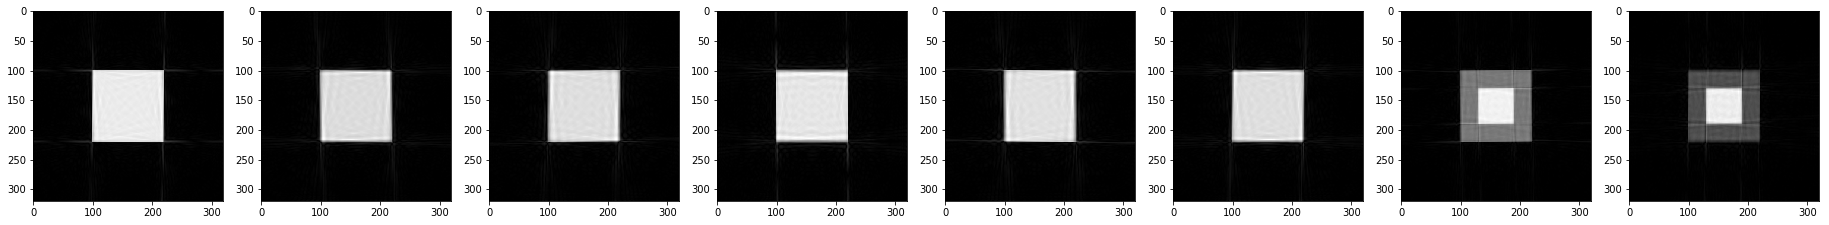

(22,)


../radialmri/simulation_and_reconstruction.py:227: RuntimeWarning: invalid value encountered in true_divide
  return curve/m;


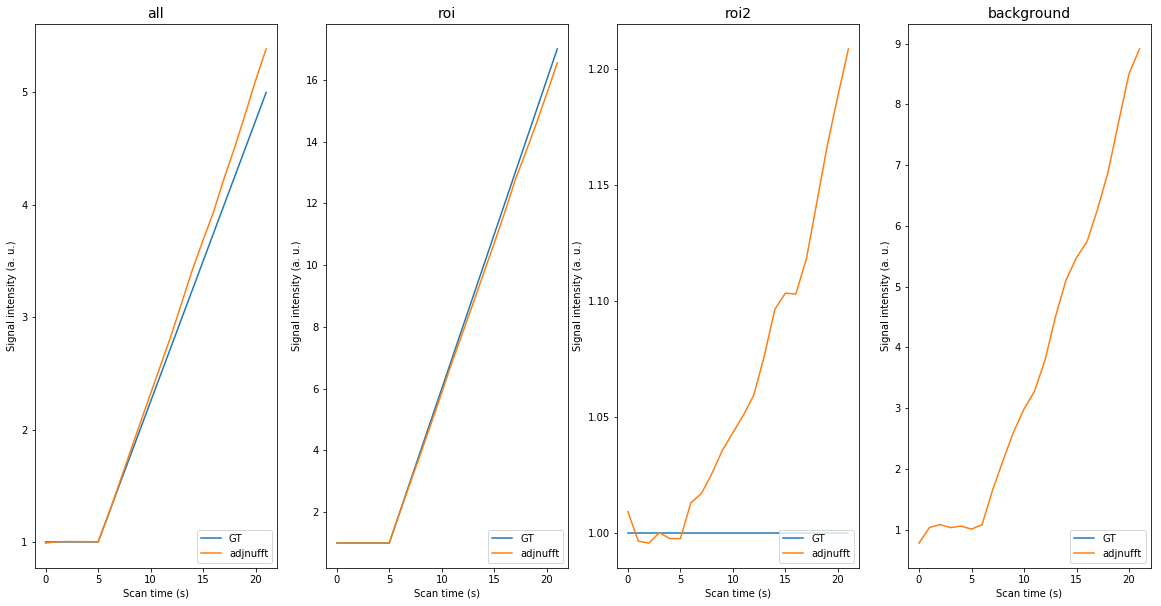

In [53]:
CG_recon_mc, nufft_recon_mc = \
RadialRecon_alternative(kspace= kspace_mc.to(device), 
            traj = traj_mc.to(device), 
            coil_sensitivities= smap_tensor, 
            w = dcomp_FL.to(device), 
            grid_size = (640, 640),
            im_size = (320, 320), 
            tolerance = 1e-10,
            lambda1 = None,
            niter = 128,
            optimizer = 'CG5')

CG_recon_complex_mc = CG_recon_mc[:,0] + 1j * CG_recon_mc[:,0]

plotcoil(np.abs(CG_recon_complex_mc))

plotcurves(x_hat = np.abs(CG_recon_complex_mc), 
           x_gt = pt.cpu(). numpy(), 
           maskdict = maskdict,
           names = ['adjnufft', 'GT'], 
           normalize = True)

0 alpha:  tensor([ 1.6049e+00, -2.4690e-08], device='cuda:0')
1 alpha:  tensor([ 5.2762e-01, -1.4578e-08], device='cuda:0')
2 alpha:  tensor([ 4.5552e-01, -3.4814e-09], device='cuda:0')
3 alpha:  tensor([ 4.7646e-01, -5.5672e-09], device='cuda:0')
4 alpha:  tensor([ 4.7710e-01, -5.0749e-09], device='cuda:0')
5 alpha:  tensor([ 4.5193e-01, -8.1295e-09], device='cuda:0')
6 alpha:  tensor([ 4.9809e-01, -7.3796e-09], device='cuda:0')
7 alpha:  tensor([ 5.4383e-01, -8.7255e-09], device='cuda:0')
8 alpha:  tensor([ 5.1809e-01, -9.6077e-09], device='cuda:0')
9 alpha:  tensor([ 4.9333e-01, -9.6759e-09], device='cuda:0')
10 alpha:  tensor([ 5.4643e-01, -9.6204e-09], device='cuda:0')
11 alpha:  tensor([ 6.4732e-01, -8.1261e-09], device='cuda:0')
12 alpha:  tensor([ 7.4026e-01, -7.9507e-09], device='cuda:0')
13 alpha:  tensor([ 8.0533e-01, -1.2442e-08], device='cuda:0')
14 alpha:  tensor([ 8.2517e-01, -1.6636e-08], device='cuda:0')
15 alpha:  tensor([ 7.9888e-01, -1.2429e-08], device='cuda:0')
16

130 alpha:  tensor([ 7.8421e-01, -3.8805e-09], device='cuda:0')
131 alpha:  tensor([ 7.9280e-01, -7.2510e-09], device='cuda:0')
132 alpha:  tensor([ 8.0518e-01, -7.0294e-09], device='cuda:0')
133 alpha:  tensor([ 7.9260e-01, -5.8532e-09], device='cuda:0')
134 alpha:  tensor([ 7.7923e-01, -1.1142e-08], device='cuda:0')
135 alpha:  tensor([ 7.2274e-01, -6.4810e-09], device='cuda:0')
136 alpha:  tensor([ 5.8132e-01, -9.3555e-09], device='cuda:0')
137 alpha:  tensor([ 6.2095e-01, -8.8796e-09], device='cuda:0')
138 alpha:  tensor([ 7.3059e-01, -4.8036e-09], device='cuda:0')
139 alpha:  tensor([ 7.8311e-01, -8.2059e-09], device='cuda:0')
140 alpha:  tensor([ 8.0910e-01, -7.7235e-09], device='cuda:0')
141 alpha:  tensor([ 7.8484e-01, -6.6366e-09], device='cuda:0')
142 alpha:  tensor([ 7.9275e-01, -7.8944e-09], device='cuda:0')
143 alpha:  tensor([ 8.1205e-01, -4.0239e-09], device='cuda:0')
144 alpha:  tensor([ 7.7354e-01, -7.4076e-09], device='cuda:0')
145 alpha:  tensor([ 8.3434e-01, -6.8553

259 alpha:  tensor([ 7.9433e-01, -9.4347e-10], device='cuda:0')
260 alpha:  tensor([ 7.8090e-01, -2.0171e-09], device='cuda:0')
261 alpha:  tensor([ 8.2362e-01, -5.6096e-09], device='cuda:0')
262 alpha:  tensor([ 7.6361e-01, -1.6384e-09], device='cuda:0')
263 alpha:  tensor([ 8.0061e-01, -1.6785e-09], device='cuda:0')
264 alpha:  tensor([ 7.4268e-01, -5.7442e-09], device='cuda:0')
265 alpha:  tensor([ 6.8460e-01, -8.0414e-09], device='cuda:0')
266 alpha:  tensor([ 6.7223e-01, -9.2705e-09], device='cuda:0')
267 alpha:  tensor([ 7.4845e-01, -2.6023e-09], device='cuda:0')
268 alpha:  tensor([ 7.6989e-01, -2.6477e-09], device='cuda:0')
269 alpha:  tensor([ 8.0851e-01, -4.7879e-09], device='cuda:0')
270 alpha:  tensor([ 7.7936e-01, -4.6408e-09], device='cuda:0')
271 alpha:  tensor([ 8.3410e-01, -4.8682e-10], device='cuda:0')
272 alpha:  tensor([ 7.8584e-01, -3.6503e-09], device='cuda:0')
273 alpha:  tensor([ 8.1644e-01, -3.6491e-09], device='cuda:0')
274 alpha:  tensor([ 7.9124e-01, -2.2264

388 alpha:  tensor([ 8.1457e-01, -1.4039e-09], device='cuda:0')
389 alpha:  tensor([ 7.9651e-01, -1.4831e-09], device='cuda:0')
390 alpha:  tensor([ 7.9826e-01, -4.6607e-09], device='cuda:0')
391 alpha:  tensor([ 7.3848e-01, -4.6588e-09], device='cuda:0')
392 alpha:  tensor([ 6.1985e-01, -6.4494e-09], device='cuda:0')
393 alpha:  tensor([ 6.0568e-01, -4.9851e-09], device='cuda:0')
394 alpha:  tensor([ 7.1303e-01, -2.1469e-09], device='cuda:0')
395 alpha:  tensor([ 7.8371e-01, -5.0804e-10], device='cuda:0')
396 alpha:  tensor([ 8.0912e-01, -2.0523e-09], device='cuda:0')
397 alpha:  tensor([ 7.9454e-01, -4.3991e-09], device='cuda:0')
398 alpha:  tensor([ 8.0118e-01, -4.0476e-09], device='cuda:0')
399 alpha:  tensor([ 7.5878e-01, -3.1830e-09], device='cuda:0')
400 alpha:  tensor([ 7.0569e-01, -6.3367e-09], device='cuda:0')
401 alpha:  tensor([ 6.6134e-01, -1.1995e-08], device='cuda:0')
402 alpha:  tensor([ 7.3048e-01, -7.0758e-09], device='cuda:0')
403 alpha:  tensor([ 7.6478e-01, -4.3065

517 alpha:  tensor([ 8.0114e-01, -2.6778e-09], device='cuda:0')
518 alpha:  tensor([ 8.0672e-01, -7.0833e-09], device='cuda:0')
519 alpha:  tensor([ 8.2393e-01, -3.3695e-09], device='cuda:0')
520 alpha:  tensor([8.0298e-01, 4.4020e-09], device='cuda:0')
521 alpha:  tensor([ 7.9282e-01, -3.3112e-09], device='cuda:0')
522 alpha:  tensor([ 7.9587e-01, -6.9033e-09], device='cuda:0')
523 alpha:  tensor([ 7.1921e-01, -3.5686e-09], device='cuda:0')
524 alpha:  tensor([ 6.0045e-01, -5.4236e-09], device='cuda:0')
525 alpha:  tensor([ 6.2420e-01, -8.5864e-09], device='cuda:0')
526 alpha:  tensor([ 7.2945e-01, -4.7083e-09], device='cuda:0')
527 alpha:  tensor([ 7.9872e-01, -1.0494e-09], device='cuda:0')
528 alpha:  tensor([ 8.0137e-01, -2.1711e-09], device='cuda:0')
529 alpha:  tensor([ 8.1550e-01, -2.4403e-09], device='cuda:0')
530 alpha:  tensor([ 7.8657e-01, -2.1891e-09], device='cuda:0')
531 alpha:  tensor([ 7.7096e-01, -5.5383e-09], device='cuda:0')
532 alpha:  tensor([ 7.1347e-01, -6.5794e-

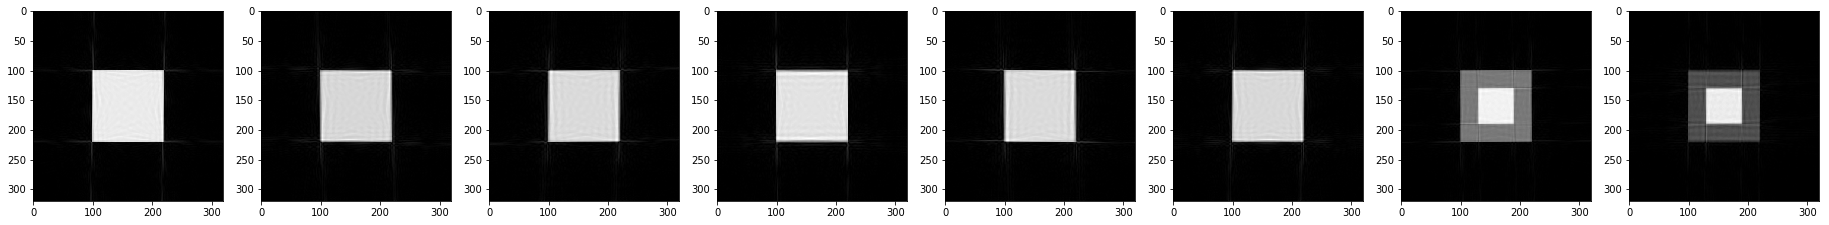

(22,)


../radialmri/simulation_and_reconstruction.py:227: RuntimeWarning: invalid value encountered in true_divide
  return curve/m;


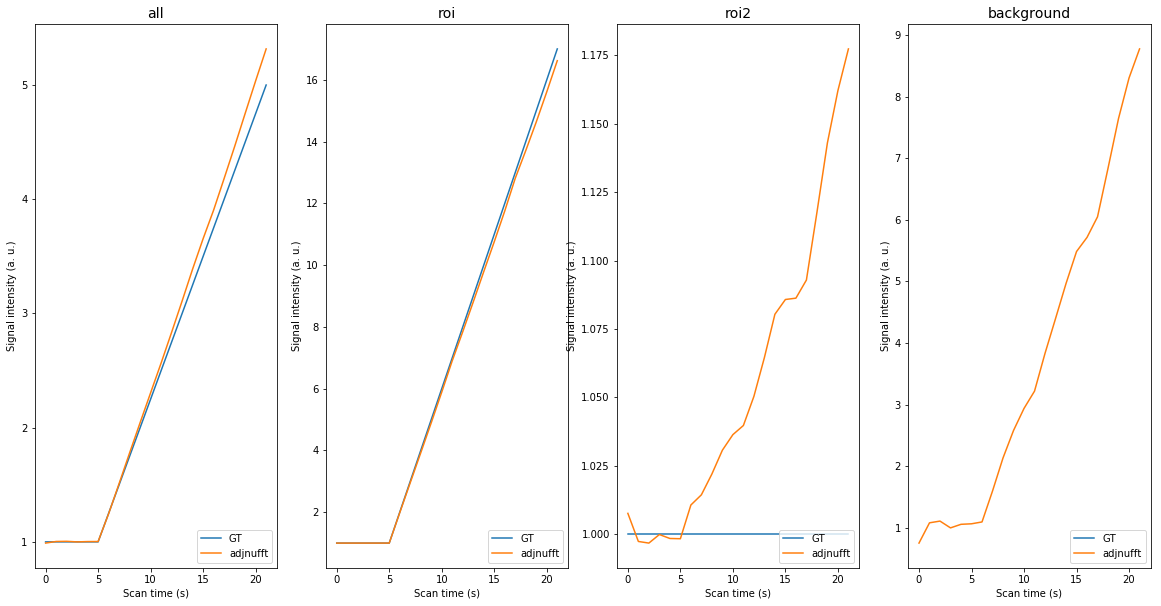

In [54]:
CG_recon_mc, nufft_recon_mc = \
RadialRecon_alternative(kspace= kspace_mc.to(device), 
            traj = traj_mc.to(device), 
            coil_sensitivities= smap_tensor, 
            w = dcomp_FL.to(device), 
            grid_size = (640, 640),
            im_size = (320, 320), 
            tolerance = 1e-10,
            lambda1 = None,
            niter = 640,
            optimizer = 'CG5')

CG_recon_complex_mc = CG_recon_mc[:,0] + 1j * CG_recon_mc[:,0]

plotcoil(np.abs(CG_recon_complex_mc))

plotcurves(x_hat = np.abs(CG_recon_complex_mc), 
           x_gt = pt.cpu(). numpy(), 
           maskdict = maskdict,
           names = ['adjnufft', 'GT'], 
           normalize = True)

## 3.1 Smaller Center ROI

../radialmri/simulation_and_reconstruction.py:23: UserWarning: Out of sync with the remove repository
  warnings.warn('Out of sync with the remove repository')


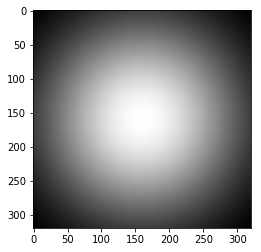

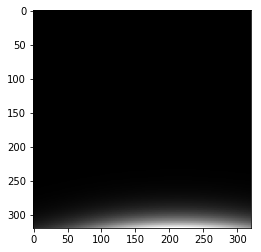

2.889131778890383 -0.49716608589137934
-2.1526274775465852 -1.1670658830592648
-1.622093988691884 -1.7344058246900484
2.8287478385239337 0.9092739544047772
0.5280129938317959 -2.8271435779785534
-1.714524318855511 1.1264511550423766
0.6238242272066996 -0.3336340689680011
-1.41669714923065 0.7836905349978327
0.31087107482287824 0.07782168141881662
-0.2978046644616015 -1.1807474077482896
1.1290060010486762 -1.2364182799445624
-2.2760309106106034 0.7493484428095636
-0.7365648083274547 0.7768073290175086
-1.0362370846869198 -1.558618858210175
-1.1868556253402964 2.1766841145463056
0.7832065628829019 1.1550753589510432


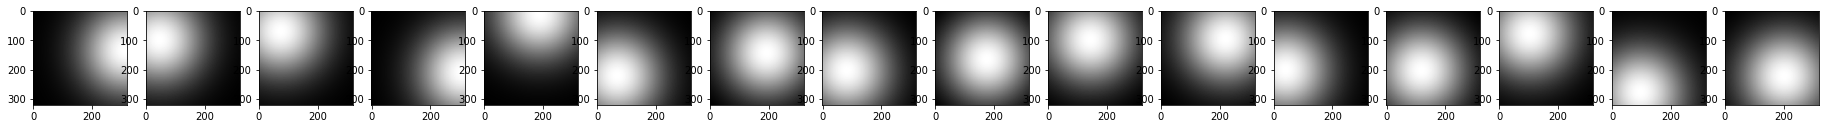

(16, 320, 320) complex128 torch.Size([22, 2, 320, 320])


In [15]:
def coil_smap_sim(h, w, x0 = 0, y0 = 0):
    #https://www.geeksforgeeks.org/how-to-generate-2-d-gaussian-array-using-numpy/
    # Initializing value of x-axis and y-axis
    # in the range -2 to +2
    x, y = np.meshgrid(np.linspace(-3, 3, h), np.linspace(-3, 3, w))
    dst = np.sqrt(x**2 + y**2)

    # Intializing sigma and muu
    sigma_x, sigma_y = 2.0, 2.0 * h / w

    # Calculating Gaussian array
    gauss = np.exp(-( (x - x0)**2 / ( 2.0 * sigma_x**2 ) \
                    + (y - y0)**2 / ( 2.0 * sigma_y**2 ) ) )
    
    return gauss

def multi_coil_smap_sim(h, w, ncoil = 16):
    res = []
    for i in range(ncoil):
        x0, y0 = np.random.uniform(-3, 3, size = 2)
        print(x0, y0)
        res.append(coil_smap_sim(h, w, x0, y0))
        
    return np.array(res)

gauss = coil_smap_sim(320, 320)

plt.imshow(gauss)
plt.show()

gauss = coil_smap_sim(320, 320, 1, 16)

plt.imshow(gauss)
plt.show()

smap = multi_coil_smap_sim(320, 320, ncoil = 16)

plotcoil(x = smap, n = 16)

smap = smap + 1j * smap
print(smap.shape, smap.dtype, pt.shape)

smap_tensor = numpy2torch(smap).permute(1, 0, 2, 3).unsqueeze(0).to(torch.float32).to(device)


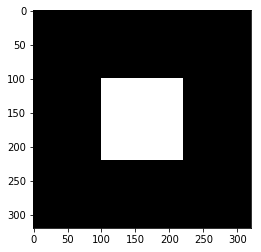

/gpfs/share/apps/anaconda3/gpu/5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([22, 1, 2, 13440])
torch.Size([22, 1, 2, 13440])
torch.Size([22, 2, 320, 320])


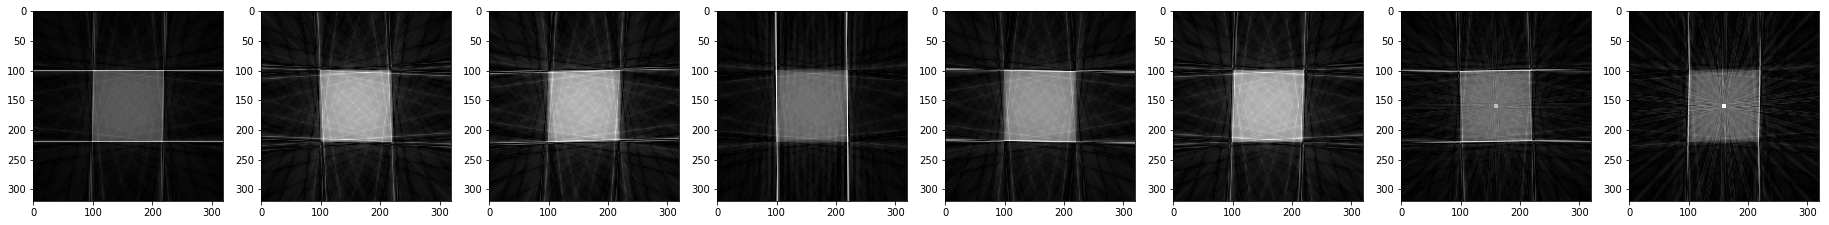

(22,)


../radialmri/simulation_and_reconstruction.py:259: RuntimeWarning: invalid value encountered in true_divide
  


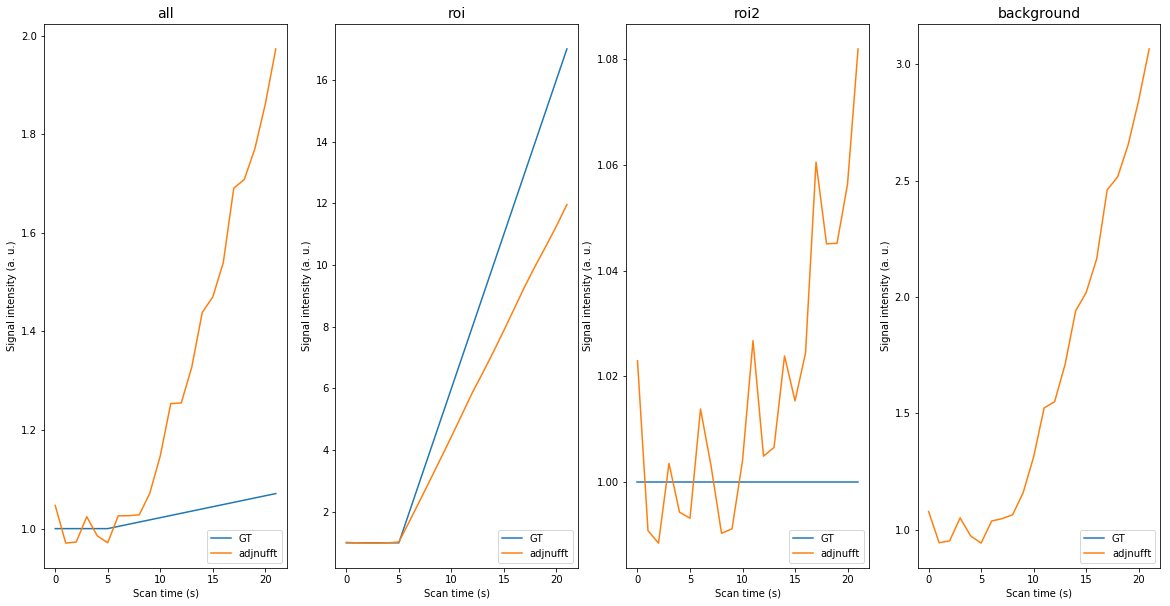

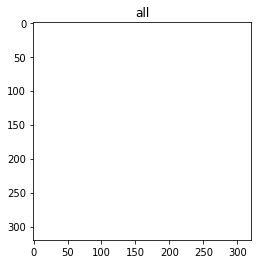

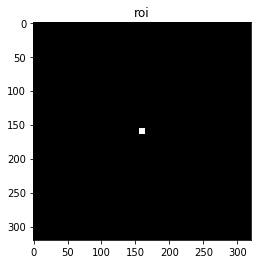

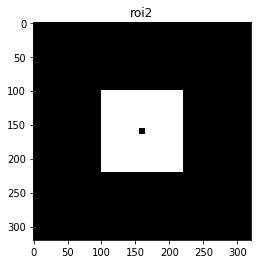

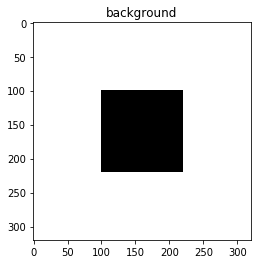

/gpfs/share/apps/anaconda3/gpu/5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([22, 1, 2, 13440])
torch.Size([22, 16, 2, 13440])
torch.Size([22, 2, 320, 320])


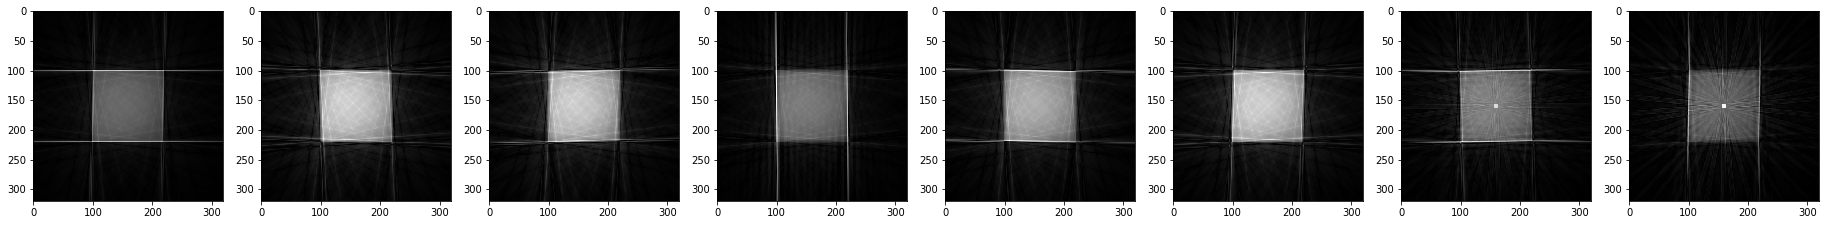

(22,)


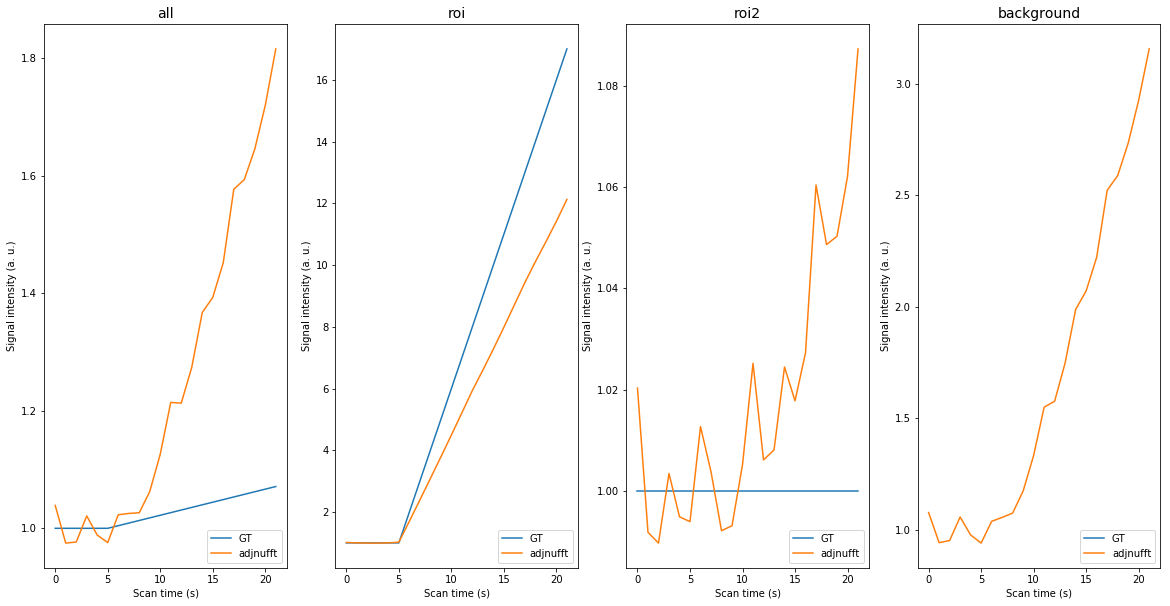

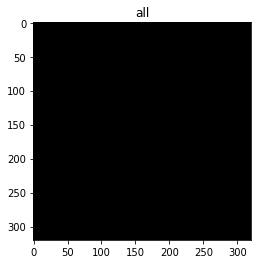

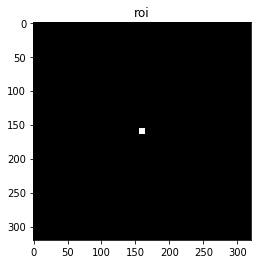

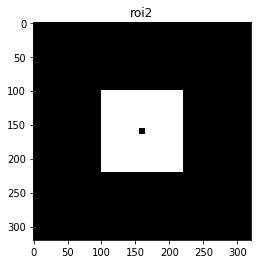

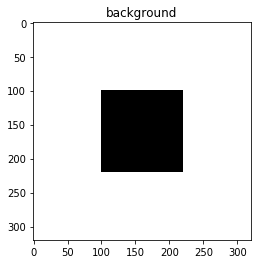

In [16]:
x, y, wx, wy, nt, x_shift, y_shift, center_ratio = 320, 320, 60, 60, 22, 0, 0, 15
pt = torch.zeros((nt, 2, 320, 320), device = device)
pt[:, :, x_shift + x // 2 - wx : x_shift + x // 2 + wx, x_shift + y // 2 - wy : x_shift + y // 2 + wy] = 1
plt.imshow(pt[0, 0].cpu(), cmap = 'gray')
plt.show()

#introduce a linear temporal variation

for i in range(5, nt):
    pt[i, : , x_shift + x // 2 - wx // center_ratio : x_shift + x // 2 + wx // center_ratio, y_shift + y // 2 - wy // center_ratio: y_shift + y // 2 + wy // center_ratio] *= (i - 4)

maskdict = {'all' : np.ones((x, y))}

maskdict['roi'] = np.zeros((x, y))
maskdict['roi'][x_shift + x // 2 - wx // center_ratio : x_shift + x // 2 + wx // center_ratio, y_shift + y // 2 - wy // center_ratio: y_shift + y // 2 + wy // center_ratio] = 1

maskdict['roi2'] = np.zeros((x, y))
maskdict['roi2'][x_shift + x // 2 - wx : x_shift + x // 2 + wx, y_shift + y // 2 - wy : y_shift + y // 2 + wy] = 1
maskdict['roi2'] -= maskdict['roi']

maskdict['background'] = maskdict['all'] - maskdict['roi'] - maskdict['roi2']


kspace, recon, traj, dcomp = RadialSimulation(target= torch.tensor(pt, dtype = torch.float32).to(device), 
                                                 spokespertime= 21, nt= 22, nc = 1, spokelength= 640, 
                                                 smap= (2 ** (-0.5)) * torch.ones((1, 1, 2, x, y) , dtype = torch.float32).to(device), 
                                                 grid_size= (640, 640), im_size= (320, 320))

plotcoil(torch.sqrt(recon[:, 0]**2 + recon[:, 1]**2).cpu(), n = 8)

plotcurves(x_hat = recon.cpu(). numpy(), 
           x_gt = pt.cpu(). numpy(), 
           maskdict = maskdict,
           names = ['adjnufft', 'GT'], 
           normalize = True)

for k, v in maskdict.items():
    plt.imshow(v, vmin = 0, vmax = 1)
    plt.title(k)
    plt.show()
    
kspace_mc, recon_mc, traj_mc, dcomp_mc = RadialSimulation(target= torch.tensor(pt, dtype = torch.float32).to(device), 
                                                 spokespertime= 21, nt= 22, nc = 1, spokelength= 640, 
                                                 #smap= (2 ** (-0.5)) * torch.ones((1, 1, 2, x, y) , dtype = torch.float32).to(device),
                                                 smap = smap_tensor,
                                                 grid_size= (640, 640), im_size= (320, 320))

plotcoil(torch.sqrt(recon_mc[:, 0]**2 + recon_mc[:, 1]**2).cpu(), n = 8)

plotcurves(x_hat = recon_mc.cpu(). numpy(), 
           x_gt = pt.cpu(). numpy(), 
           maskdict = maskdict,
           names = ['adjnufft', 'GT'], 
           normalize = True)

for k, v in maskdict.items():
    #plt.imshow(v, vmin = 0, vmax = 1)
    plt.imshow(v)
    plt.title(k)
    plt.show()

torch.Size([22, 16, 2, 13440]) cpu
torch.Size([22, 2, 320, 320])


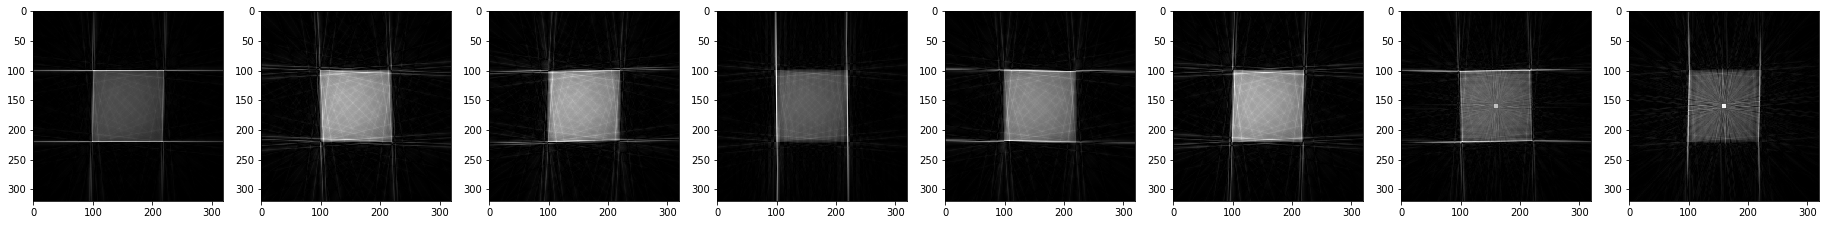

(22,)


../radialmri/simulation_and_reconstruction.py:259: RuntimeWarning: invalid value encountered in true_divide
  


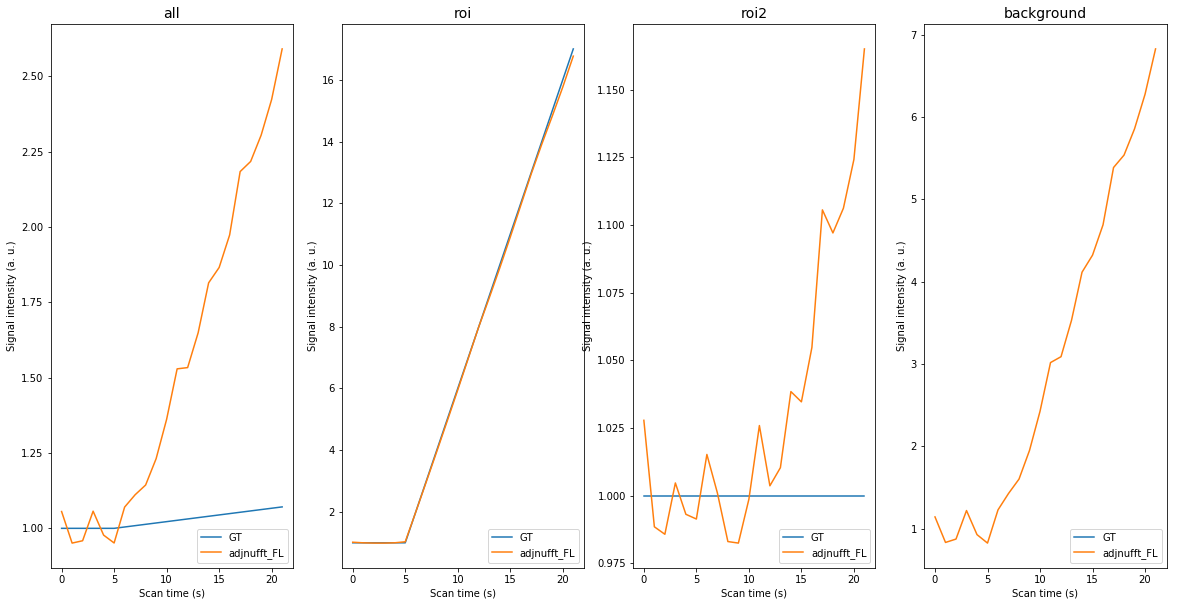

In [17]:
def dcomp_reference(traj, nt = 22, nc = 1):
    dcomp = torch.sqrt(traj[0, 0]**2 + traj[0, 1]**2)
    dcomp = dcomp / max(dcomp)
    dcomp = dcomp.repeat(nt, nc, 2, 1)
    return dcomp

dcomp_FL = dcomp_reference(traj, nt = 22, nc = 16)
print(dcomp_FL.shape, dcomp_FL.device)

radialmodel = RadialModel(grid_size= (640, 640), im_size= (320, 320)).to(device, dtype)
adj_nufft_FLdcomp = radialmodel.adjoint(y = kspace_mc.to(device) * torch.sqrt(dcomp_FL.to(device)),
                    k = traj.to(device), 
                    coil_sensitivities = smap_tensor, 
                    w = dcomp_FL.to(device))

print(adj_nufft_FLdcomp.shape)
adjnufft_FLdcom = torch.sqrt(adj_nufft_FLdcomp[:, 0]**2 + adj_nufft_FLdcomp[:, 1]**2).cpu()
plotcoil(adjnufft_FLdcom)

plotcurves(x_hat = np.abs(adj_nufft_FLdcomp.cpu().numpy()), 
           x_gt = pt.cpu(). numpy(), 
           maskdict = maskdict,
           names = ['adjnufft_FL', 'GT'], 
           normalize = True)

0 alpha:  tensor([ 9.6018e-01, -4.7611e-09], device='cuda:0')
1 alpha:  tensor([ 6.5288e-01, -7.9109e-09], device='cuda:0')
2 alpha:  tensor([ 5.5089e-01, -5.0337e-09], device='cuda:0')
3 alpha:  tensor([ 5.5450e-01, -2.5808e-09], device='cuda:0')
4 alpha:  tensor([ 5.1587e-01, -2.6735e-09], device='cuda:0')
5 alpha:  tensor([ 4.5784e-01, -8.4155e-09], device='cuda:0')
6 alpha:  tensor([ 3.9494e-01, -7.8736e-09], device='cuda:0')
7 alpha:  tensor([ 6.1165e-01, -6.7121e-09], device='cuda:0')
8 alpha:  tensor([ 5.6268e-01, -4.8571e-09], device='cuda:0')
9 alpha:  tensor([ 5.6911e-01, -7.5943e-09], device='cuda:0')
10 alpha:  tensor([ 5.3478e-01, -1.0727e-08], device='cuda:0')
11 alpha:  tensor([ 5.9871e-01, -6.9770e-09], device='cuda:0')
12 alpha:  tensor([ 6.9983e-01, -7.1736e-09], device='cuda:0')
13 alpha:  tensor([ 7.1016e-01, -7.2415e-09], device='cuda:0')
14 alpha:  tensor([ 7.7785e-01, -1.8058e-09], device='cuda:0')
15 alpha:  tensor([ 7.7690e-01, -3.3894e-09], device='cuda:0')
16

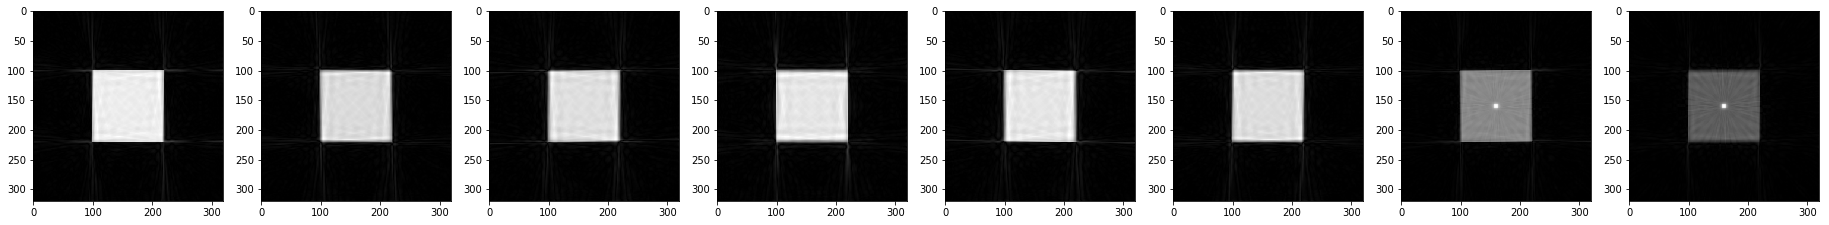

(22,)


../radialmri/simulation_and_reconstruction.py:259: RuntimeWarning: invalid value encountered in true_divide
  


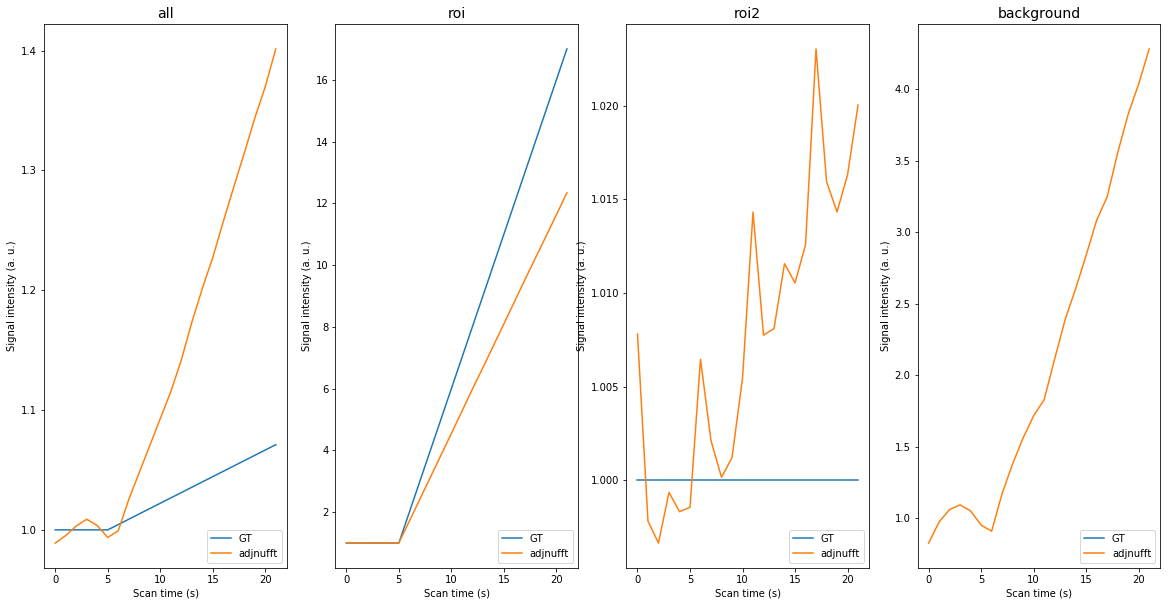

In [18]:
CG_recon_mc, nufft_recon_mc = \
RadialRecon_alternative(kspace= kspace_mc.to(device), 
            traj = traj_mc.to(device), 
            coil_sensitivities= smap_tensor, 
            w = dcomp_FL.to(device), 
            grid_size = (640, 640),
            im_size = (320, 320), 
            tolerance = 1e-10,
            lambda1 = None,
            niter = 32,
            optimizer = 'CG5')

CG_recon_complex_mc = CG_recon_mc[:,0] + 1j * CG_recon_mc[:,0]

plotcoil(np.abs(CG_recon_complex_mc))

plotcurves(x_hat = np.abs(CG_recon_complex_mc), 
           x_gt = pt.cpu(). numpy(), 
           maskdict = maskdict,
           names = ['adjnufft', 'GT'], 
           normalize = True)

0 alpha:  tensor([ 1.3463e+00, -8.0008e-09], device='cuda:0')
1 alpha:  tensor([ 9.3656e-01, -1.1977e-08], device='cuda:0')
2 alpha:  tensor([ 7.8571e-01, -5.8778e-09], device='cuda:0')
3 alpha:  tensor([ 7.4074e-01, -7.5689e-09], device='cuda:0')
4 alpha:  tensor([ 5.9472e-01, -8.2994e-09], device='cuda:0')
5 alpha:  tensor([ 5.6523e-01, -1.5223e-08], device='cuda:0')
6 alpha:  tensor([ 5.6157e-01, -7.1673e-09], device='cuda:0')
7 alpha:  tensor([ 9.0514e-01, -5.5558e-09], device='cuda:0')
8 alpha:  tensor([ 7.8625e-01, -4.1032e-09], device='cuda:0')
9 alpha:  tensor([ 8.4009e-01, -6.2700e-09], device='cuda:0')
10 alpha:  tensor([ 8.2264e-01, -8.7451e-09], device='cuda:0')
11 alpha:  tensor([ 8.4533e-01, -7.0213e-09], device='cuda:0')
12 alpha:  tensor([ 9.1231e-01, -1.6642e-08], device='cuda:0')
13 alpha:  tensor([ 8.6561e-01, -1.6273e-08], device='cuda:0')
14 alpha:  tensor([ 9.3456e-01, -9.5989e-09], device='cuda:0')
15 alpha:  tensor([ 9.8360e-01, -4.4420e-09], device='cuda:0')
16

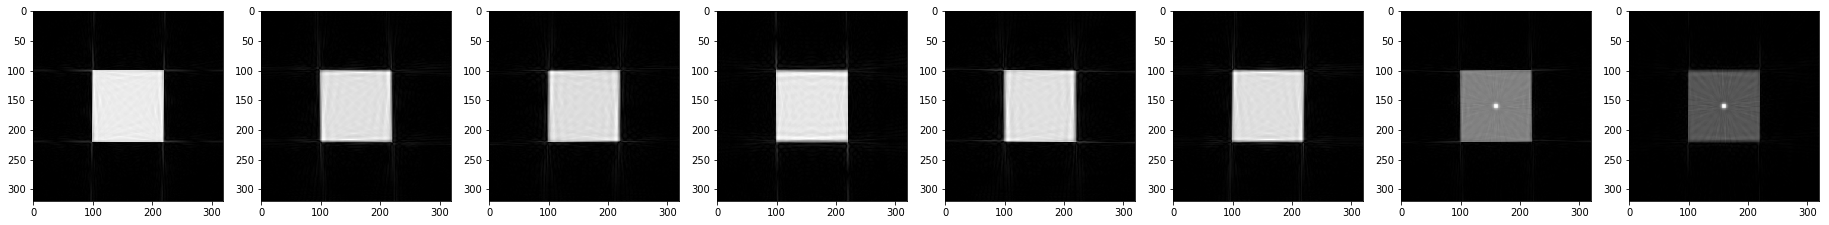

(22,)


../radialmri/simulation_and_reconstruction.py:227: RuntimeWarning: invalid value encountered in true_divide
  return curve/m;


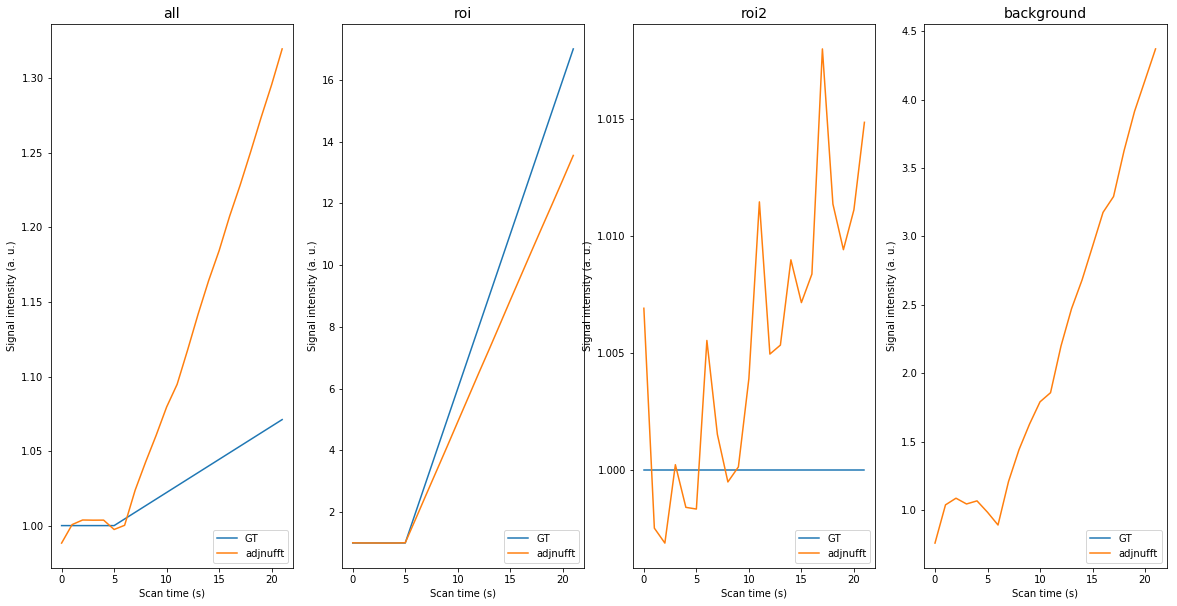

In [12]:
CG_recon_mc, nufft_recon_mc = \
RadialRecon_alternative(kspace= kspace_mc.to(device), 
            traj = traj_mc.to(device), 
            coil_sensitivities= smap_tensor, 
            w = dcomp_FL.to(device), 
            grid_size = (640, 640),
            im_size = (320, 320), 
            tolerance = 1e-10,
            lambda1 = None,
            niter = 128,
            optimizer = 'CG5')

CG_recon_complex_mc = CG_recon_mc[:,0] + 1j * CG_recon_mc[:,0]

plotcoil(np.abs(CG_recon_complex_mc))

plotcurves(x_hat = np.abs(CG_recon_complex_mc), 
           x_gt = pt.cpu(). numpy(), 
           maskdict = maskdict,
           names = ['adjnufft', 'GT'], 
           normalize = True)

0 alpha:  tensor([ 9.6018e-01, -5.2333e-09], device='cuda:0')
1 alpha:  tensor([ 6.5288e-01, -7.8624e-09], device='cuda:0')
2 alpha:  tensor([ 5.5089e-01, -5.1842e-09], device='cuda:0')
3 alpha:  tensor([ 5.5450e-01, -2.7124e-09], device='cuda:0')
4 alpha:  tensor([ 5.1587e-01, -2.8697e-09], device='cuda:0')
5 alpha:  tensor([ 4.5784e-01, -7.3253e-09], device='cuda:0')
6 alpha:  tensor([ 3.9494e-01, -7.3487e-09], device='cuda:0')
7 alpha:  tensor([ 6.1165e-01, -6.6931e-09], device='cuda:0')
8 alpha:  tensor([ 5.6268e-01, -4.8367e-09], device='cuda:0')
9 alpha:  tensor([ 5.6911e-01, -7.8793e-09], device='cuda:0')
10 alpha:  tensor([ 5.3478e-01, -9.8475e-09], device='cuda:0')
11 alpha:  tensor([ 5.9871e-01, -6.7075e-09], device='cuda:0')
12 alpha:  tensor([ 6.9983e-01, -6.8489e-09], device='cuda:0')
13 alpha:  tensor([ 7.1016e-01, -7.4784e-09], device='cuda:0')
14 alpha:  tensor([ 7.7785e-01, -1.5364e-09], device='cuda:0')
15 alpha:  tensor([ 7.7690e-01, -3.8569e-09], device='cuda:0')
16

130 alpha:  tensor([ 8.1679e-01, -1.2626e-09], device='cuda:0')
131 alpha:  tensor([ 7.9995e-01, -2.5032e-09], device='cuda:0')
132 alpha:  tensor([ 8.0491e-01, -1.0201e-09], device='cuda:0')
133 alpha:  tensor([ 8.0884e-01, -2.7389e-09], device='cuda:0')
134 alpha:  tensor([ 7.9872e-01, -2.8718e-09], device='cuda:0')
135 alpha:  tensor([ 7.9806e-01, -1.7665e-09], device='cuda:0')
136 alpha:  tensor([ 8.1637e-01, -1.3073e-09], device='cuda:0')
137 alpha:  tensor([ 8.1797e-01, -2.2609e-09], device='cuda:0')
138 alpha:  tensor([ 8.0887e-01, -1.8520e-09], device='cuda:0')
139 alpha:  tensor([8.0240e-01, 1.0977e-10], device='cuda:0')
140 alpha:  tensor([ 7.8891e-01, -2.0899e-09], device='cuda:0')
141 alpha:  tensor([ 7.7501e-01, -4.1167e-09], device='cuda:0')
142 alpha:  tensor([ 7.0644e-01, -5.9825e-09], device='cuda:0')
143 alpha:  tensor([ 5.9809e-01, -6.4829e-09], device='cuda:0')
144 alpha:  tensor([ 6.6963e-01, -9.2425e-09], device='cuda:0')
145 alpha:  tensor([ 7.4542e-01, -4.6031e-

260 alpha:  tensor([ 6.7162e-01, -1.0550e-08], device='cuda:0')
261 alpha:  tensor([ 6.9040e-01, -3.8450e-09], device='cuda:0')
262 alpha:  tensor([ 7.7887e-01, -2.4792e-09], device='cuda:0')
263 alpha:  tensor([7.8632e-01, 9.5957e-11], device='cuda:0')
264 alpha:  tensor([ 8.0597e-01, -1.0891e-09], device='cuda:0')
265 alpha:  tensor([7.8719e-01, 1.4471e-09], device='cuda:0')
266 alpha:  tensor([8.1462e-01, 2.1325e-09], device='cuda:0')
267 alpha:  tensor([ 7.8444e-01, -3.8396e-09], device='cuda:0')
268 alpha:  tensor([ 8.0665e-01, -6.5590e-10], device='cuda:0')
269 alpha:  tensor([ 7.4717e-01, -1.3814e-09], device='cuda:0')
270 alpha:  tensor([ 6.5735e-01, -8.9165e-09], device='cuda:0')
271 alpha:  tensor([ 6.0834e-01, -8.2381e-09], device='cuda:0')
272 alpha:  tensor([ 6.9138e-01, -3.5683e-09], device='cuda:0')
273 alpha:  tensor([ 7.7108e-01, -1.4851e-09], device='cuda:0')
274 alpha:  tensor([8.0890e-01, 6.4999e-10], device='cuda:0')
275 alpha:  tensor([7.9444e-01, 7.8412e-11], dev

390 alpha:  tensor([ 6.4853e-01, -5.9910e-09], device='cuda:0')
391 alpha:  tensor([ 6.7837e-01, -4.0999e-09], device='cuda:0')
392 alpha:  tensor([ 7.3478e-01, -1.0806e-09], device='cuda:0')
393 alpha:  tensor([ 7.4435e-01, -7.3680e-09], device='cuda:0')
394 alpha:  tensor([ 6.5193e-01, -1.0076e-08], device='cuda:0')
395 alpha:  tensor([ 6.3239e-01, -7.6409e-09], device='cuda:0')
396 alpha:  tensor([ 7.0674e-01, -4.0218e-09], device='cuda:0')
397 alpha:  tensor([7.6571e-01, 6.1282e-10], device='cuda:0')
398 alpha:  tensor([7.9857e-01, 1.9697e-09], device='cuda:0')
399 alpha:  tensor([ 8.0185e-01, -4.0086e-09], device='cuda:0')
400 alpha:  tensor([8.0488e-01, 2.7009e-09], device='cuda:0')
401 alpha:  tensor([8.0754e-01, 2.9884e-09], device='cuda:0')
402 alpha:  tensor([ 8.0791e-01, -5.2363e-09], device='cuda:0')
403 alpha:  tensor([7.9952e-01, 1.2603e-09], device='cuda:0')
404 alpha:  tensor([ 8.1827e-01, -2.6312e-11], device='cuda:0')
405 alpha:  tensor([ 8.1566e-01, -1.5313e-10], dev

520 alpha:  tensor([ 7.5665e-01, -1.6524e-09], device='cuda:0')
521 alpha:  tensor([ 6.9323e-01, -1.0698e-08], device='cuda:0')
522 alpha:  tensor([ 6.6556e-01, -7.3627e-09], device='cuda:0')
523 alpha:  tensor([ 7.1458e-01, -3.4093e-09], device='cuda:0')
524 alpha:  tensor([7.6704e-01, 3.7639e-10], device='cuda:0')
525 alpha:  tensor([7.7644e-01, 2.0626e-10], device='cuda:0')
526 alpha:  tensor([ 8.0885e-01, -5.0039e-10], device='cuda:0')
527 alpha:  tensor([ 8.1017e-01, -2.4049e-11], device='cuda:0')
528 alpha:  tensor([8.1228e-01, 3.8548e-09], device='cuda:0')
529 alpha:  tensor([8.0694e-01, 8.7067e-10], device='cuda:0')
530 alpha:  tensor([ 8.1052e-01, -3.1873e-09], device='cuda:0')
531 alpha:  tensor([ 7.8887e-01, -6.1101e-11], device='cuda:0')
532 alpha:  tensor([ 7.1173e-01, -2.4279e-09], device='cuda:0')
533 alpha:  tensor([ 6.1344e-01, -9.1323e-09], device='cuda:0')
534 alpha:  tensor([ 6.4671e-01, -4.8719e-09], device='cuda:0')
535 alpha:  tensor([ 7.3500e-01, -2.2518e-09], d

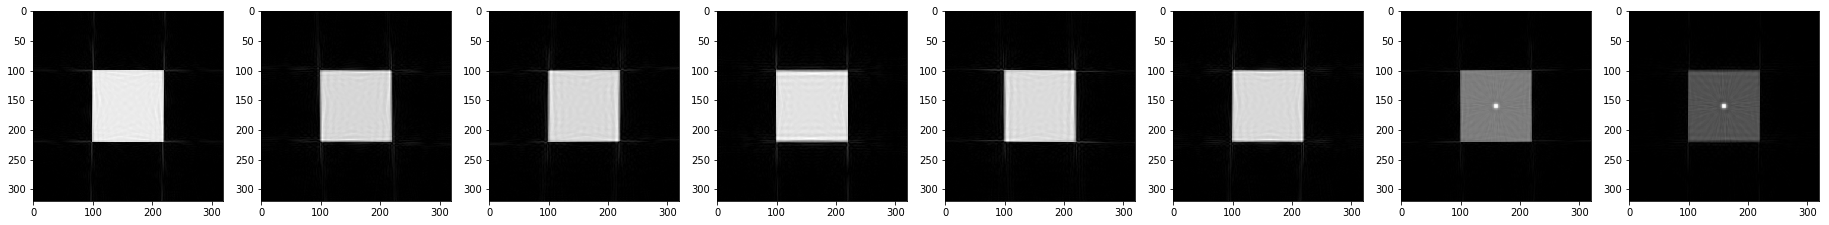

(22,)


../radialmri/simulation_and_reconstruction.py:259: RuntimeWarning: invalid value encountered in true_divide
  


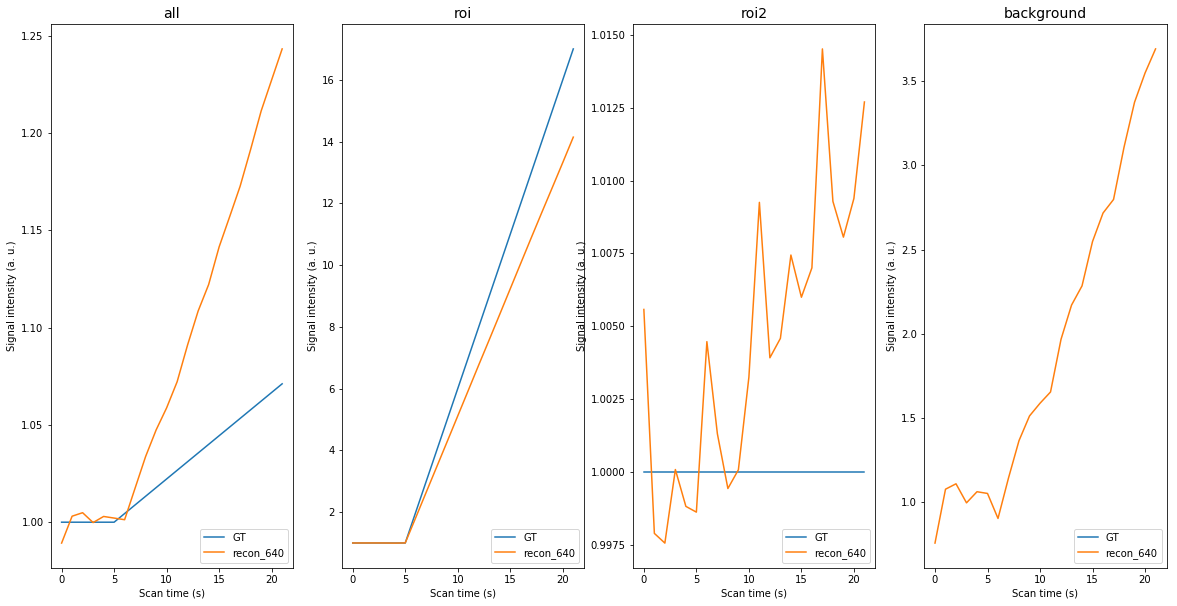

In [19]:
CG_recon_mc, nufft_recon_mc = \
RadialRecon_alternative(kspace= kspace_mc.to(device), 
            traj = traj_mc.to(device), 
            coil_sensitivities= smap_tensor, 
            w = dcomp_FL.to(device), 
            grid_size = (640, 640),
            im_size = (320, 320), 
            tolerance = 1e-10,
            lambda1 = None,
            niter = 640,
            optimizer = 'CG5')

CG_recon_complex_mc = CG_recon_mc[:,0] + 1j * CG_recon_mc[:,0]

plotcoil(np.abs(CG_recon_complex_mc))

plotcurves(x_hat = np.abs(CG_recon_complex_mc), 
           x_gt = pt.cpu(). numpy(), 
           maskdict = maskdict,
           names = ['recon_640', 'GT'], 
           normalize = True)

In [20]:
## 4.1 Larger Center ROI 

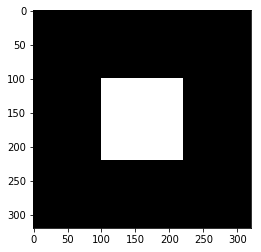

/gpfs/share/apps/anaconda3/gpu/5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([22, 1, 2, 13440])
torch.Size([22, 1, 2, 13440])
torch.Size([22, 2, 320, 320])


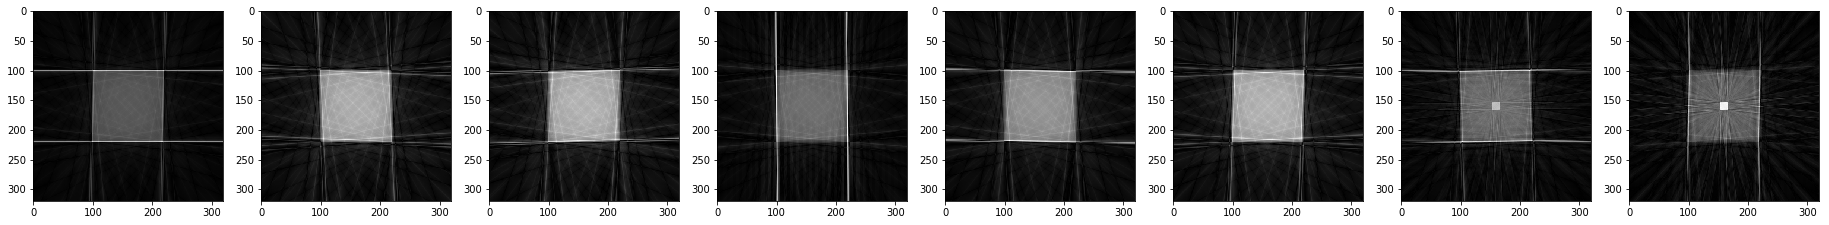

(22,)


../radialmri/simulation_and_reconstruction.py:259: RuntimeWarning: invalid value encountered in true_divide
  


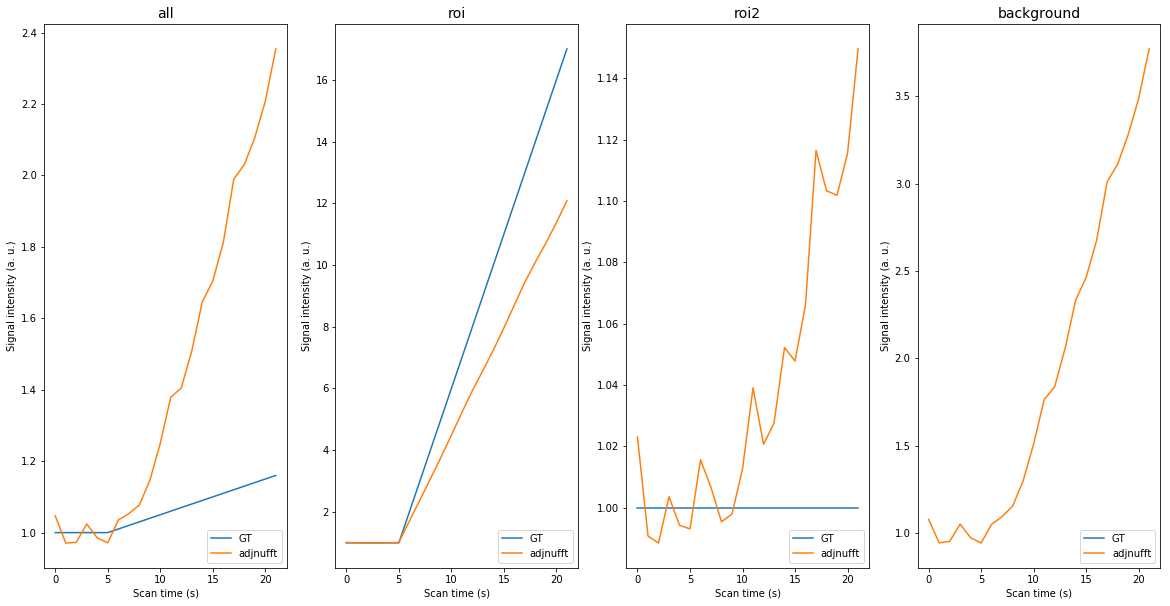

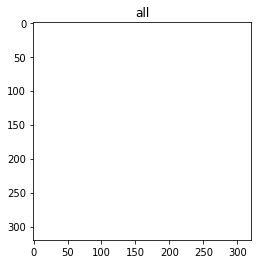

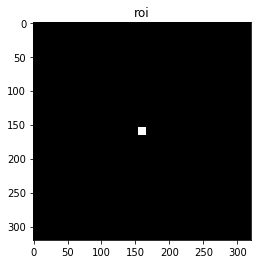

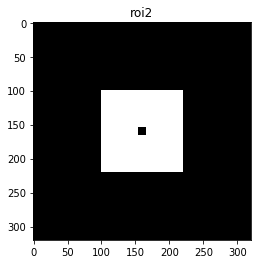

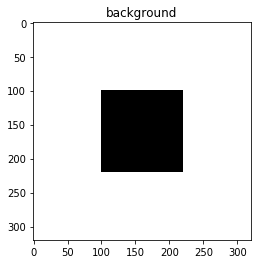

/gpfs/share/apps/anaconda3/gpu/5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([22, 1, 2, 13440])
torch.Size([22, 16, 2, 13440])
torch.Size([22, 2, 320, 320])


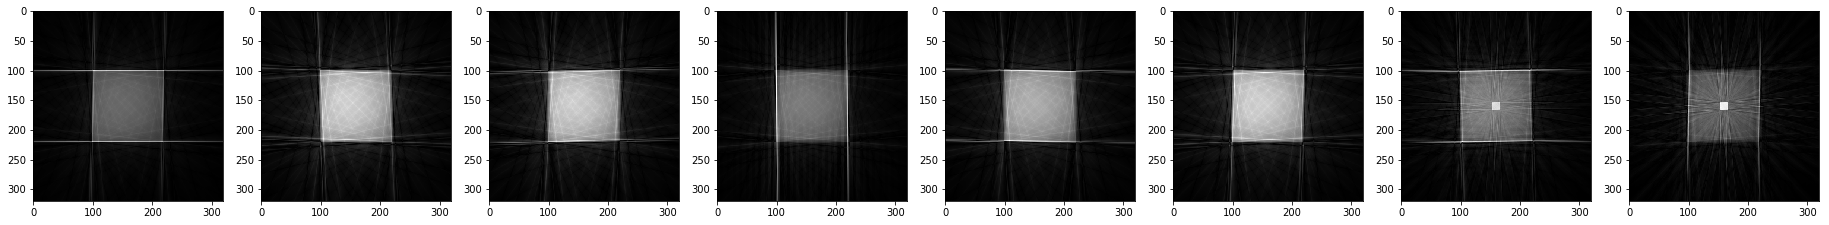

(22,)


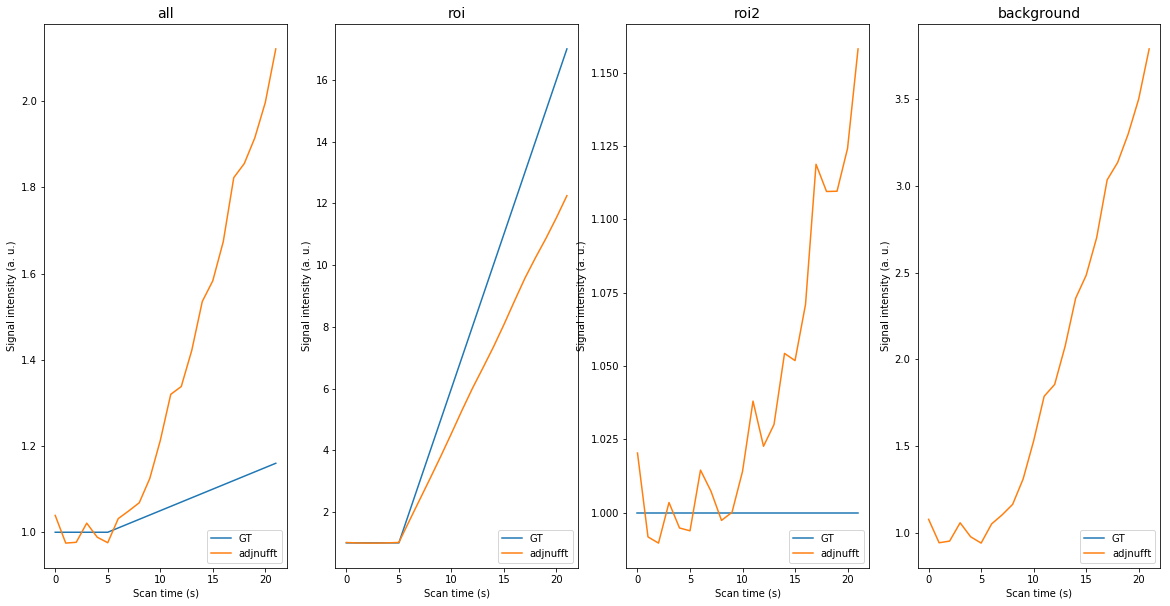

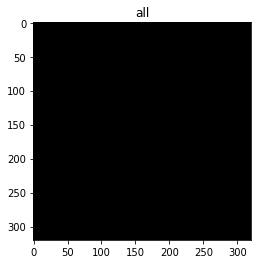

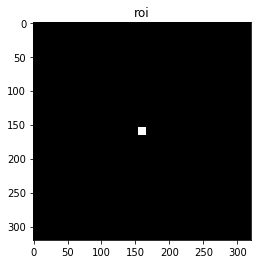

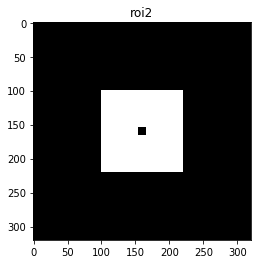

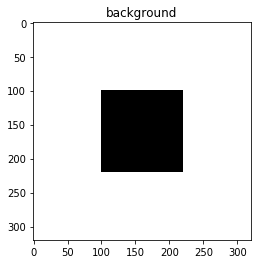

In [21]:
x, y, wx, wy, nt, x_shift, y_shift, center_ratio = 320, 320, 60, 60, 22, 0, 0, 10
pt = torch.zeros((nt, 2, 320, 320), device = device)
pt[:, :, x_shift + x // 2 - wx : x_shift + x // 2 + wx, x_shift + y // 2 - wy : x_shift + y // 2 + wy] = 1
plt.imshow(pt[0, 0].cpu(), cmap = 'gray')
plt.show()

#introduce a linear temporal variation

for i in range(5, nt):
    pt[i, : , x_shift + x // 2 - wx // center_ratio : x_shift + x // 2 + wx // center_ratio, y_shift + y // 2 - wy // center_ratio: y_shift + y // 2 + wy // center_ratio] *= (i - 4)

maskdict = {'all' : np.ones((x, y))}

maskdict['roi'] = np.zeros((x, y))
maskdict['roi'][x_shift + x // 2 - wx // center_ratio : x_shift + x // 2 + wx // center_ratio, y_shift + y // 2 - wy // center_ratio: y_shift + y // 2 + wy // center_ratio] = 1

maskdict['roi2'] = np.zeros((x, y))
maskdict['roi2'][x_shift + x // 2 - wx : x_shift + x // 2 + wx, y_shift + y // 2 - wy : y_shift + y // 2 + wy] = 1
maskdict['roi2'] -= maskdict['roi']

maskdict['background'] = maskdict['all'] - maskdict['roi'] - maskdict['roi2']


kspace, recon, traj, dcomp = RadialSimulation(target= torch.tensor(pt, dtype = torch.float32).to(device), 
                                                 spokespertime= 21, nt= 22, nc = 1, spokelength= 640, 
                                                 smap= (2 ** (-0.5)) * torch.ones((1, 1, 2, x, y) , dtype = torch.float32).to(device), 
                                                 grid_size= (640, 640), im_size= (320, 320))

plotcoil(torch.sqrt(recon[:, 0]**2 + recon[:, 1]**2).cpu(), n = 8)

plotcurves(x_hat = recon.cpu(). numpy(), 
           x_gt = pt.cpu(). numpy(), 
           maskdict = maskdict,
           names = ['adjnufft', 'GT'], 
           normalize = True)

for k, v in maskdict.items():
    plt.imshow(v, vmin = 0, vmax = 1)
    plt.title(k)
    plt.show()
    
kspace_mc, recon_mc, traj_mc, dcomp_mc = RadialSimulation(target= torch.tensor(pt, dtype = torch.float32).to(device), 
                                                 spokespertime= 21, nt= 22, nc = 1, spokelength= 640, 
                                                 #smap= (2 ** (-0.5)) * torch.ones((1, 1, 2, x, y) , dtype = torch.float32).to(device),
                                                 smap = smap_tensor,
                                                 grid_size= (640, 640), im_size= (320, 320))

plotcoil(torch.sqrt(recon_mc[:, 0]**2 + recon_mc[:, 1]**2).cpu(), n = 8)

plotcurves(x_hat = recon_mc.cpu(). numpy(), 
           x_gt = pt.cpu(). numpy(), 
           maskdict = maskdict,
           names = ['adjnufft', 'GT'], 
           normalize = True)

for k, v in maskdict.items():
    #plt.imshow(v, vmin = 0, vmax = 1)
    plt.imshow(v)
    plt.title(k)
    plt.show()

0 alpha:  tensor([ 9.4401e-01, -1.8343e-08], device='cuda:0')
1 alpha:  tensor([ 6.5080e-01, -1.5707e-08], device='cuda:0')
2 alpha:  tensor([ 5.4016e-01, -4.0284e-09], device='cuda:0')
3 alpha:  tensor([ 5.2731e-01, -5.4988e-09], device='cuda:0')
4 alpha:  tensor([ 5.2335e-01, -3.4919e-09], device='cuda:0')
5 alpha:  tensor([ 4.8712e-01, -8.0044e-09], device='cuda:0')
6 alpha:  tensor([ 4.9370e-01, -7.0573e-09], device='cuda:0')
7 alpha:  tensor([ 4.9971e-01, -8.1068e-09], device='cuda:0')
8 alpha:  tensor([ 5.1638e-01, -8.2771e-09], device='cuda:0')
9 alpha:  tensor([ 7.2866e-01, -1.0487e-08], device='cuda:0')
10 alpha:  tensor([ 5.2492e-01, -1.0469e-08], device='cuda:0')
11 alpha:  tensor([ 5.9274e-01, -1.1317e-08], device='cuda:0')
12 alpha:  tensor([ 6.9166e-01, -1.0394e-08], device='cuda:0')
13 alpha:  tensor([ 7.3022e-01, -6.8912e-09], device='cuda:0')
14 alpha:  tensor([ 7.2524e-01, -6.0012e-09], device='cuda:0')
15 alpha:  tensor([ 7.3498e-01, -1.1818e-08], device='cuda:0')
16

130 alpha:  tensor([8.1671e-01, 4.2095e-10], device='cuda:0')
131 alpha:  tensor([ 7.9182e-01, -3.8893e-09], device='cuda:0')
132 alpha:  tensor([ 7.9431e-01, -2.4017e-09], device='cuda:0')
133 alpha:  tensor([ 8.1471e-01, -1.9221e-09], device='cuda:0')
134 alpha:  tensor([ 8.0207e-01, -2.0196e-09], device='cuda:0')
135 alpha:  tensor([ 7.9277e-01, -4.0222e-09], device='cuda:0')
136 alpha:  tensor([ 8.1277e-01, -2.2929e-09], device='cuda:0')
137 alpha:  tensor([ 8.0331e-01, -1.6253e-09], device='cuda:0')
138 alpha:  tensor([ 8.0424e-01, -3.9859e-09], device='cuda:0')
139 alpha:  tensor([8.0629e-01, 1.8681e-10], device='cuda:0')
140 alpha:  tensor([7.8676e-01, 7.6035e-10], device='cuda:0')
141 alpha:  tensor([ 7.8543e-01, -5.0779e-09], device='cuda:0')
142 alpha:  tensor([ 7.1354e-01, -6.3499e-09], device='cuda:0')
143 alpha:  tensor([ 6.0152e-01, -6.6771e-09], device='cuda:0')
144 alpha:  tensor([ 6.5918e-01, -5.9048e-09], device='cuda:0')
145 alpha:  tensor([ 7.3300e-01, -3.2053e-09],

259 alpha:  tensor([ 6.5258e-01, -9.0581e-09], device='cuda:0')
260 alpha:  tensor([ 6.9143e-01, -8.4723e-09], device='cuda:0')
261 alpha:  tensor([ 7.4080e-01, -3.2206e-09], device='cuda:0')
262 alpha:  tensor([7.9468e-01, 7.4630e-10], device='cuda:0')
263 alpha:  tensor([8.0236e-01, 4.8625e-10], device='cuda:0')
264 alpha:  tensor([ 8.0505e-01, -2.9583e-09], device='cuda:0')
265 alpha:  tensor([ 7.8634e-01, -1.0191e-09], device='cuda:0')
266 alpha:  tensor([8.1185e-01, 1.1456e-09], device='cuda:0')
267 alpha:  tensor([ 7.9620e-01, -3.4218e-09], device='cuda:0')
268 alpha:  tensor([7.9975e-01, 2.2574e-10], device='cuda:0')
269 alpha:  tensor([7.8617e-01, 2.0180e-10], device='cuda:0')
270 alpha:  tensor([ 6.9875e-01, -6.8677e-09], device='cuda:0')
271 alpha:  tensor([ 6.1486e-01, -1.0957e-08], device='cuda:0')
272 alpha:  tensor([ 6.4648e-01, -6.0027e-09], device='cuda:0')
273 alpha:  tensor([ 7.2490e-01, -3.2754e-09], device='cuda:0')
274 alpha:  tensor([ 8.0631e-01, -2.3435e-09], dev

389 alpha:  tensor([ 6.6477e-01, -8.7365e-09], device='cuda:0')
390 alpha:  tensor([ 6.7160e-01, -7.1894e-09], device='cuda:0')
391 alpha:  tensor([ 7.3472e-01, -6.8193e-09], device='cuda:0')
392 alpha:  tensor([ 7.8285e-01, -6.7624e-10], device='cuda:0')
393 alpha:  tensor([ 7.9107e-01, -2.1078e-09], device='cuda:0')
394 alpha:  tensor([ 7.2241e-01, -3.9069e-09], device='cuda:0')
395 alpha:  tensor([ 6.2786e-01, -1.1746e-08], device='cuda:0')
396 alpha:  tensor([ 6.3111e-01, -6.9467e-09], device='cuda:0')
397 alpha:  tensor([ 7.3260e-01, -1.6771e-09], device='cuda:0')
398 alpha:  tensor([7.6445e-01, 2.3592e-10], device='cuda:0')
399 alpha:  tensor([ 8.0395e-01, -2.6775e-09], device='cuda:0')
400 alpha:  tensor([ 7.9238e-01, -1.1102e-09], device='cuda:0')
401 alpha:  tensor([ 8.1631e-01, -6.1444e-10], device='cuda:0')
402 alpha:  tensor([ 8.1129e-01, -3.2220e-10], device='cuda:0')
403 alpha:  tensor([ 7.9842e-01, -3.3302e-10], device='cuda:0')
404 alpha:  tensor([ 8.2813e-01, -2.5822e-

518 alpha:  tensor([ 7.6493e-01, -1.9823e-09], device='cuda:0')
519 alpha:  tensor([ 7.6817e-01, -3.9772e-09], device='cuda:0')
520 alpha:  tensor([ 7.1213e-01, -7.1697e-09], device='cuda:0')
521 alpha:  tensor([ 6.6334e-01, -9.6895e-09], device='cuda:0')
522 alpha:  tensor([ 7.0059e-01, -4.3248e-09], device='cuda:0')
523 alpha:  tensor([ 7.5175e-01, -1.4209e-09], device='cuda:0')
524 alpha:  tensor([ 7.9042e-01, -3.0622e-09], device='cuda:0')
525 alpha:  tensor([7.9686e-01, 1.3154e-10], device='cuda:0')
526 alpha:  tensor([8.0805e-01, 1.6467e-09], device='cuda:0')
527 alpha:  tensor([ 8.1743e-01, -9.9454e-10], device='cuda:0')
528 alpha:  tensor([ 8.0968e-01, -2.2103e-09], device='cuda:0')
529 alpha:  tensor([8.1271e-01, 2.4649e-10], device='cuda:0')
530 alpha:  tensor([8.0129e-01, 5.0367e-10], device='cuda:0')
531 alpha:  tensor([ 8.2701e-01, -7.7117e-10], device='cuda:0')
532 alpha:  tensor([ 7.9535e-01, -3.5893e-09], device='cuda:0')
533 alpha:  tensor([ 7.6274e-01, -1.2488e-09], d

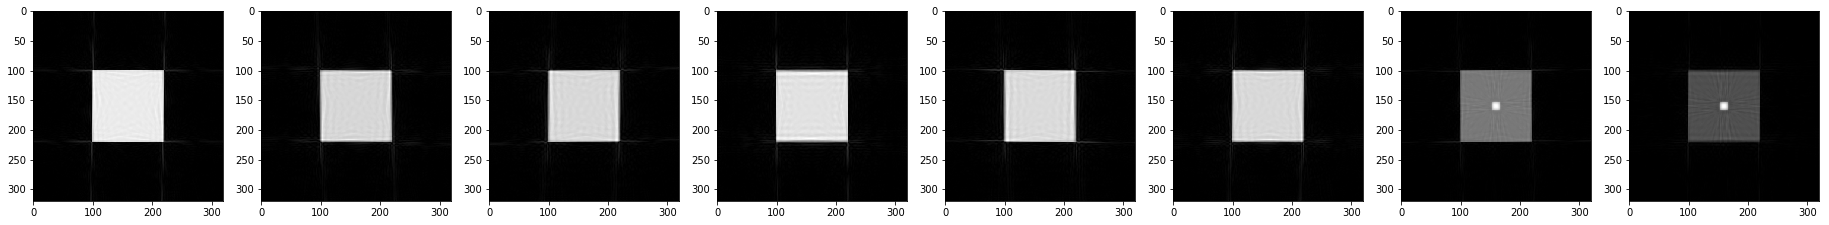

(22,)


../radialmri/simulation_and_reconstruction.py:259: RuntimeWarning: invalid value encountered in true_divide
  


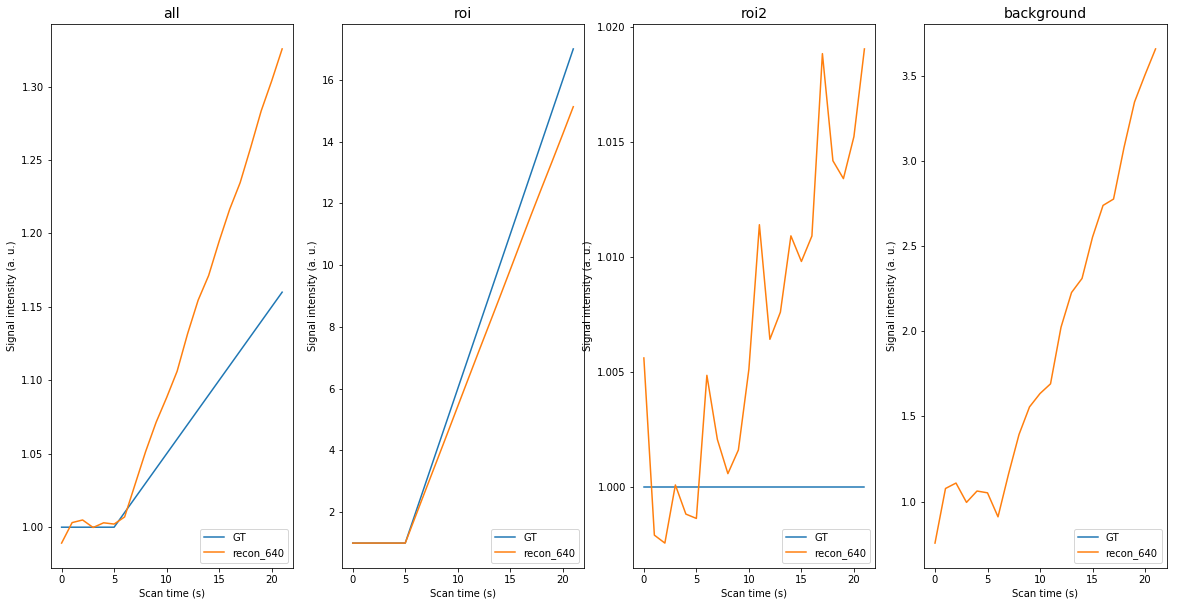

In [22]:
CG_recon_mc, nufft_recon_mc = \
RadialRecon_alternative(kspace= kspace_mc.to(device), 
            traj = traj_mc.to(device), 
            coil_sensitivities= smap_tensor, 
            w = dcomp_FL.to(device), 
            grid_size = (640, 640),
            im_size = (320, 320), 
            tolerance = 1e-10,
            lambda1 = None,
            niter = 640,
            optimizer = 'CG5')

CG_recon_complex_mc = CG_recon_mc[:,0] + 1j * CG_recon_mc[:,0]

plotcoil(np.abs(CG_recon_complex_mc))

plotcurves(x_hat = np.abs(CG_recon_complex_mc), 
           x_gt = pt.cpu(). numpy(), 
           maskdict = maskdict,
           names = ['recon_640', 'GT'], 
           normalize = True)